# Analysis of Argo and Seal data South of 60S

### Temperature and Salinity

##### by Nick Young and Fabio Machado 

In [1]:
from netCDF4 import Dataset, num2date
from datetime import datetime
import glob
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import calendar
import csv
from scipy.stats import describe
from scipy import interpolate
from tqdm import tqdm_notebook as tqdm
import oceansdb
#import seawater as sw
#from seawater.library import T90conv

In [2]:
def load_netcdf(path = "Argo_South_60"):
    # load_netcdf function input: path - default is "Argo_South_60"
    files = glob.glob("data/" + path + "/**/*.nc", recursive=True)
    # glob.glob - returns a list of all the files in a given folder with the extension 'nc'
    # recursive=true - keeps on looking for all the files till the end, or the last file that exist
    
    # creating lists working on objects
    data = {
        "lat": [],
        "lon": [],
        "datetime": [],
        "pressure": [],
        "temperature": [],
        "salinity": []
    }
    
    for f in tqdm(files):
        # tqdm - make your loops show a progress meter
        d = Dataset(f)
        ####filename = "{}".format(f)
        
        # DATASET - Creating/Opening/Closing a netCDF file. 
        #This is the method used to open an existing netCDF file.
        lat = d.variables["LATITUDE"][:]
        mask = lat < -60
        lon = d.variables["LONGITUDE"][:]
        data["lat"].extend(lat[mask])
        data["lon"].extend(lon[mask])
        #1 The extend () method adds the specified list elements to the end of the current list.
        #2 This method does not return any value but add the content to existing list.
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        #1 getncattr - reads the attributes of given variable i.e units
        dates = num2date(juld, units, "standard")
        #1 num2date - converts the format of the loaded datetime to standard format YYYY-MM-dd
        data["datetime"].extend(dates[mask])
        data["pressure"].extend(d.variables["PRES_ADJUSTED"][:][mask])
        data["temperature"].extend(d.variables["TEMP_ADJUSTED"][:][mask])
        try:
            data["salinity"].extend(d.variables["PSAL_ADJUSTED"][:][mask])
        except:
            data["salinity"].extend(np.full(len(mask), np.nan))
    
    #1 array() - allows one to do operations on a list
    #2 NumPy was imported as np
    #3 If we want to do math on a homogeneous array of numeric data, then it is much better to use NumPy, 
    #  which can automatically vectorize operations on complex multi-dimensional arrays
    
    for k,v in data.items():
        data[k] = np.array(v)
    return data

def plot(lats, lons, z = [], title = "Argo profiles south of 60S", cbtitle = "Number of points in bin", vmax=None):
    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, 0, 20))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    plt.title("{} {}".format(len(lats), title))

    x, y = m(lons, lats)
    if len(z) == 0:
        hh, locx, locy = np.histogram2d(x, y, bins=100)
        # Sort the points by density, so that the densest points are plotted last
        z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
        #print(describe(z))
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    #m.imshow(heatmap, interpolation='bicubic', cmap="jet")
    m.scatter(x, y, c=z, s=5, alpha=1, cmap="jet", vmax=vmax)
    cb = plt.colorbar()
    cb.set_label(cbtitle, rotation=270)
    plt.show()

def plot_time(dts, title, label):
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    for i, dt in enumerate(dts):
    #1 enumerate() method adds a counter to an iterable and returns it in a form of enumerate object.
    #  This enumerate object can then be used directly in for loops or be converted into a list of tuples using list() method.
        k = label[i]
        df = pd.DataFrame({k: dt})
        #1 Pandas was imported as pd
        #2 Dataframe class - class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)
        #  Two-dimensional size-mutable, potentially heterogeneous tabular data structure with labeled axes (rows and columns).
        #  Arithmetic operations align on both row and column labels. 
        #  Can be thought of as a dict-like container for Series objects
        df = df.groupby(by=df[k].dt.date).count()
        #1 groupby - groups data by a certain specified variable type
        df.plot(ax=ax, style='.', markersize=3)
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.set_title(title, fontsize=18)
        ax.set_xlabel("Time",fontsize=14)
        ax.set_ylabel("Number of profiles",fontsize=14)
        #ax.set_xlabel("")
        ax.legend(fontsize=14)
    plt.show()

In [3]:
argo = load_netcdf()

<ipython-input-2-38fc4432685a>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm(files):


In [ ]:
plot(argo["lat"], argo["lon"], vmax=100)
sst = [x[0] for x in argo["temperature"]]
plot(argo["lat"], argo["lon"], sst, title = "Argo SST", cbtitle = "Temperature °C")
max_depth = [np.nanmax(x) for x in argo["pressure"]]
plot(argo["lat"], argo["lon"], max_depth, title = "Argo Max Depth", cbtitle = "Depth (decibar pressure)")

In [ ]:
print(min(argo["datetime"]), max(argo["datetime"]))
plot_time([argo["datetime"]], "Argo float dailystamps", ["Argo"])

In [4]:
seal = load_netcdf("seal")

<ipython-input-2-38fc4432685a>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm(files):


In [ ]:
plot(seal["lat"], seal["lon"], title = "Seal data south of 60S", vmax=100)
sst = [x[0] for x in seal["temperature"]]
plot(seal["lat"], seal["lon"], sst, title = "Seal SST", cbtitle = "Temperature °C")
max_depth = [np.nanmax(x) for x in seal["pressure"]]
plot(seal["lat"], seal["lon"], max_depth, title = "Seal Max Depth", cbtitle = "Depth (decibar pressure)")

In [ ]:
print(min(seal["datetime"]), max(seal["datetime"]))
plot_time([seal["datetime"]], "Seal data dailystamps", ["Elephant seal"])

In [5]:
all_lats = np.concatenate((seal["lat"], argo["lat"]))
all_lons = np.concatenate((seal["lon"], argo["lon"]))
#plot(all_lats, all_lons, title="Argo + seal data south of 60S", vmax=100)

In [ ]:
plot_time([seal["datetime"], argo["datetime"]], "Argo + seal data dailystamps", ["Seal", "Argo"])

In [ ]:
a3_sum = sum(argo["lat"]> -89.)
mask_out = argo["lat"] < -75
mask_in = (argo["lat"] < -60) & (argo["lat"] > -75)
a1_sum = sum(mask_out)
a2_sum = sum(mask_in)
print("Argo","\nA) Number of profiles to the south of 75S =",a1_sum,
      "\nB) Number of profiles between 60 and 75S =", a2_sum, 
      "\nC) A+B =", (a2_sum+a1_sum),
      "\nD) Total number of profiles to the south of 60S =", a3_sum)

s1_sum = sum(seal["lat"]> -89.)
mask_half_out = (seal["lat"] < -60) & (seal["lat"] > -89)
s2_sum = sum(mask_half_out)
mask_out = seal["lat"] < -75
mask_in = (seal["lat"] < -60) & (seal["lat"] > -75)
s3_sum = sum(mask_out)
s4_sum = sum(mask_in)
print("Seal","\nE) Number of profiles to the south of 75S =",s3_sum, 
      "\nF) Number of profiles between 60 and 75S =", s4_sum, 
      "\nG) E+F =", (s4_sum+s3_sum), 
      "\nH) Total number of profiles to the south of 60S =", s1_sum, 
      "\nI) Total number of profiles to the south of 60S =",s2_sum)

In [6]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(-1.5, 1950, "4.%d" % (i+1), va="center", ha="center", fontsize=12, color='black')
        ax1.text(-1., 1950, "Total of Seal Profiles = {}".format(n_seal_profiles), 
                 va="center", ha="left", fontsize=12, color='black')
        ax3.text(-1., 1950, "Total of Argo Profiles = {}".format(n_argo_profiles), 
                 va="center", ha="left", fontsize=12, color='black')
        #ax1.text(2., 1750, 'Boundaries:\nLat (-{})-(-{})\nLon ({})-({})'.format(lat_i,lat_f,lon_i,lon_f), 
        #        va="center", ha="center", fontsize=12, color='black')
        ax.set_ylim(p_max, p_min); 
        ax.set_xlim(t_min, t_max)
        ax.tick_params(axis="both", direction='inout', which='major', labelsize=16)
        ax1.tick_params(labelbottom=False, labelleft=True)
        ax2.tick_params(labelbottom=False, labelleft=False)
        ax3.tick_params(labelbottom=True, labelleft=True)
        ax4.tick_params(labelbottom=True, labelleft=False)

Number of Seal Profile in the window 5
[74147 74148 74149 98835 98836]
[-2 -1  0  1  2]


<ipython-input-74-086638b46261>:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-74-086638b46261>:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-74-086638b46261>:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

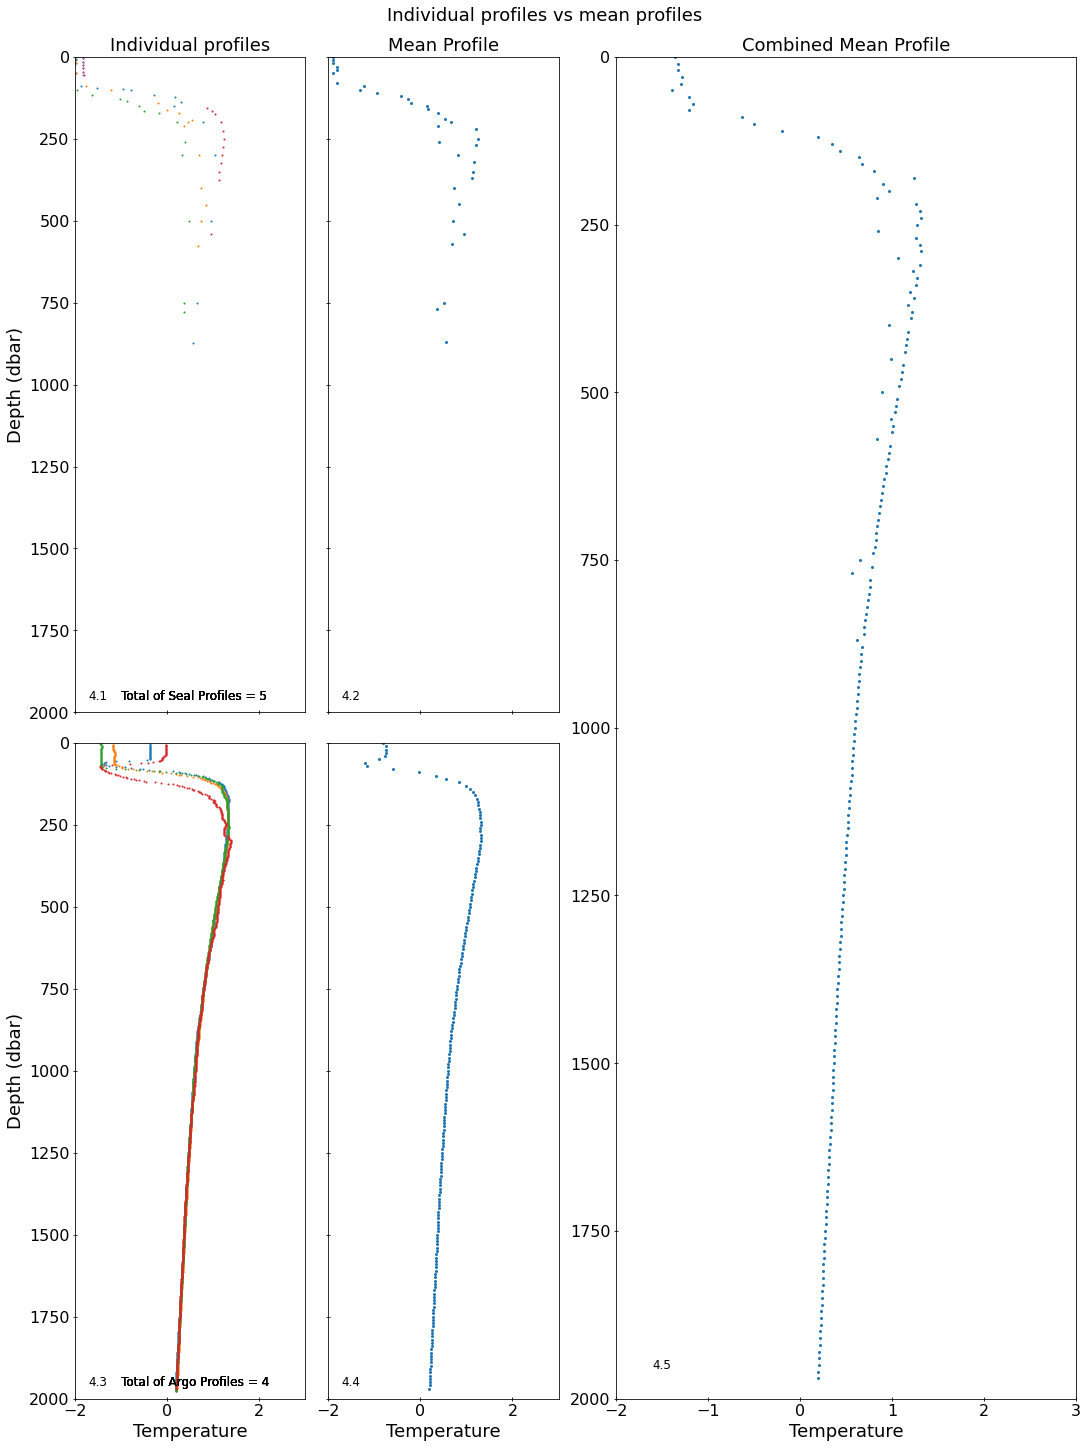

In [74]:
# This subroutine plot Seal Vertical Profiles and the Mean Profile from the Grid System
# It is necessary to run the subroutine ...
#   where "argo_temp_grid_withdepth" or "argo_sal_grid_withdepth" is calculated
        
fig = plt.figure(constrained_layout=True, figsize=(15,20))
gs = GridSpec(3, 4, figure=fig)

# Defining Geographycal Boundaries
lat_i = 63.5 ; lat_f = 64.5 ; # <-- 1º res ###   0.5º res --> lat_i = 63.25 ; lat_f = 63.75 ; 
# i = northermost # f = southermost 
lon_i = 29.5 ; lon_f = 30.5; # <-- 1º res ###   0.5º res --> #lon_i = 105.25 ; lon_f = 105.75; 
# i = westermost # f = eastermost 

# Grid system cell related to the geographycal boundaries
lat_grid = 4; lon_grid = 210;

# Maximum and minimum Temperature in the plot
t_max = 3; t_min = -2;
# Maximum and minimum Salinity in the plot
s_max = 36.; s_min = 33.;
# Maximum and minimum Temperature in the plot
p_max = 2000; p_min = 0;

mask_seal = ((seal["lat"] < -lat_i) & (seal["lat"] > -lat_f) & (seal["lon"] > lon_i) & (seal["lon"] < lon_f))  
mask_argo = ((argo["lat"] < -lat_i) & (argo["lat"] > -lat_f) & (argo["lon"] > lon_i) & (argo["lon"] < lon_f)) 

n_seal_profiles = len(np.flatnonzero(mask_seal))
n_indivivual_profiles = len(np.flatnonzero(mask_seal))
n_argo_profiles = len(np.flatnonzero(mask_argo))
print("Number of Seal Profile in the window", len(np.flatnonzero(mask_seal)))
print(np.flatnonzero(mask_seal))

depth = np.arange(p_min, p_max, 10)
xaxis = np.arange(t_min, t_max, 1)
print(xaxis)
for i in np.flatnonzero(mask_seal):
    temp_seal = seal["temperature"][i]
    pressure_seal = seal["pressure"][i]
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(temp_seal, pressure_seal,'.', markersize=2)
ax1.set_ylabel("Depth (dbar)", fontsize="18")
ax1.set_title("Individual profiles".format(n_seal_profiles), fontsize="18")


ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
ax2.set_title("Mean Profile", fontsize="18")

for i in np.flatnonzero(mask_argo):
    temp_argo = argo["temperature"][i]
    pressure_argo = argo["pressure"][i]
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(temp_argo, pressure_argo,'.', markersize=2)
ax3.set_xlabel("Temperature", fontsize="18"); 
ax3.set_ylabel("Depth (dbar)", fontsize="18")

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
ax4.set_xlabel("Temperature", fontsize="18")

ax5 = fig.add_subplot(gs[:, 2:])
ax5.plot(combined_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
ax5.set_xlabel("Temperature", fontsize="18")
#ax5.tick_params(axis="y", direction='inout', labelsize=16)
#ax5.tick_params(axis="x", direction='inout', labelsize=16)
#ax5.set_ylim(2000, 0); 
#ax5.set_xlim(t_min, t_max)
ax5.set_title("Combined Mean Profile", fontsize="18")

#fig.suptitle('Boundaries: Lat (-{})-(-{}) - Lon ({})-({})\nCel grid: Lat (-{}) - Lon ({})'.format(lat_i,lat_f,lon_i,lon_f,lat_grid, lon_grid), fontsize="18")
fig.suptitle("Individual profiles vs mean profiles", fontsize="18")
format_axes(fig)

plt.show()

In [123]:
import seaborn as sns
import pylab as plot
params = {'legend.fontsize': 14,
          'legend.handlelength': 1,
          'legend.labelspacing': 0.25,
          'legend.handletextpad': 0.2,
          'legend.frameon': False,
          'legend.markerscale': 2.0,
          'font.size': 20}
plot.rcParams.update(params)

def format_axes_a(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(-1.5, 1950, "4.%d" % (i+1), va="center", ha="center", fontsize=14, color='black')
        ax.tick_params(axis="both", direction='inout', which='major', labelsize=16, labelbottom=True, labelleft=True)
        ax.set_ylim(p_max, p_min); 
        ax.set_xlim(t_min, t_max)
        ax1.set_ylabel("Depth (dbar)")
        ax2.set_ylabel("Depth (dbar)", fontsize="20")
        ax2.set_xlabel("Temperature (ºC)")
        ax4.set_xlabel("Temperature (ºC)")
        ax6.set_xlabel("Temperature (ºC)")
        ax7.set_xlabel("Temperature (ºC)")
        ax1.tick_params(labelbottom=False)
        ax3.tick_params(labelbottom=False, labelleft=False)
        ax4.tick_params(labelleft=False)
        ax5.tick_params(labelbottom=False)
        ax7.tick_params(labelbottom=True, labelleft=True)
        
def vert_prof_filter (vprofile, window, polyorder):
    data = vprofile.interpolate(method='linear', limit= 200, limit_area="Inside")
    #print("vertical profile ==> ", data)
    #print("Vertical profile shape ==> ", data.shape)
    y_smooth=signal.savgol_filter(data,
                                  window_length=window, # window size used for filtering
                                  polyorder=polyorder, # order of fitted polynomial
                                  mode='nearest', cval=5), # Value to fill past the edges of the input if mode is ‘constant’. Default is 0.0.
    #data_in_array = np.array(y_smooth) 
    ##print("data_in_array.shape",data_in_array.shape)
    ##print("data_in_array ==> ", data_in_array)    
    return np.array(y_smooth)

<ipython-input-124-372d9be1ff3a>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-124-372d9be1ff3a>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-124-372d9be1ff3a>:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 

seal 5 [74147 74148 74149 98835 98836]
argo 4 [62105 62107 62108 62110]


No handles with labels found to put in legend.


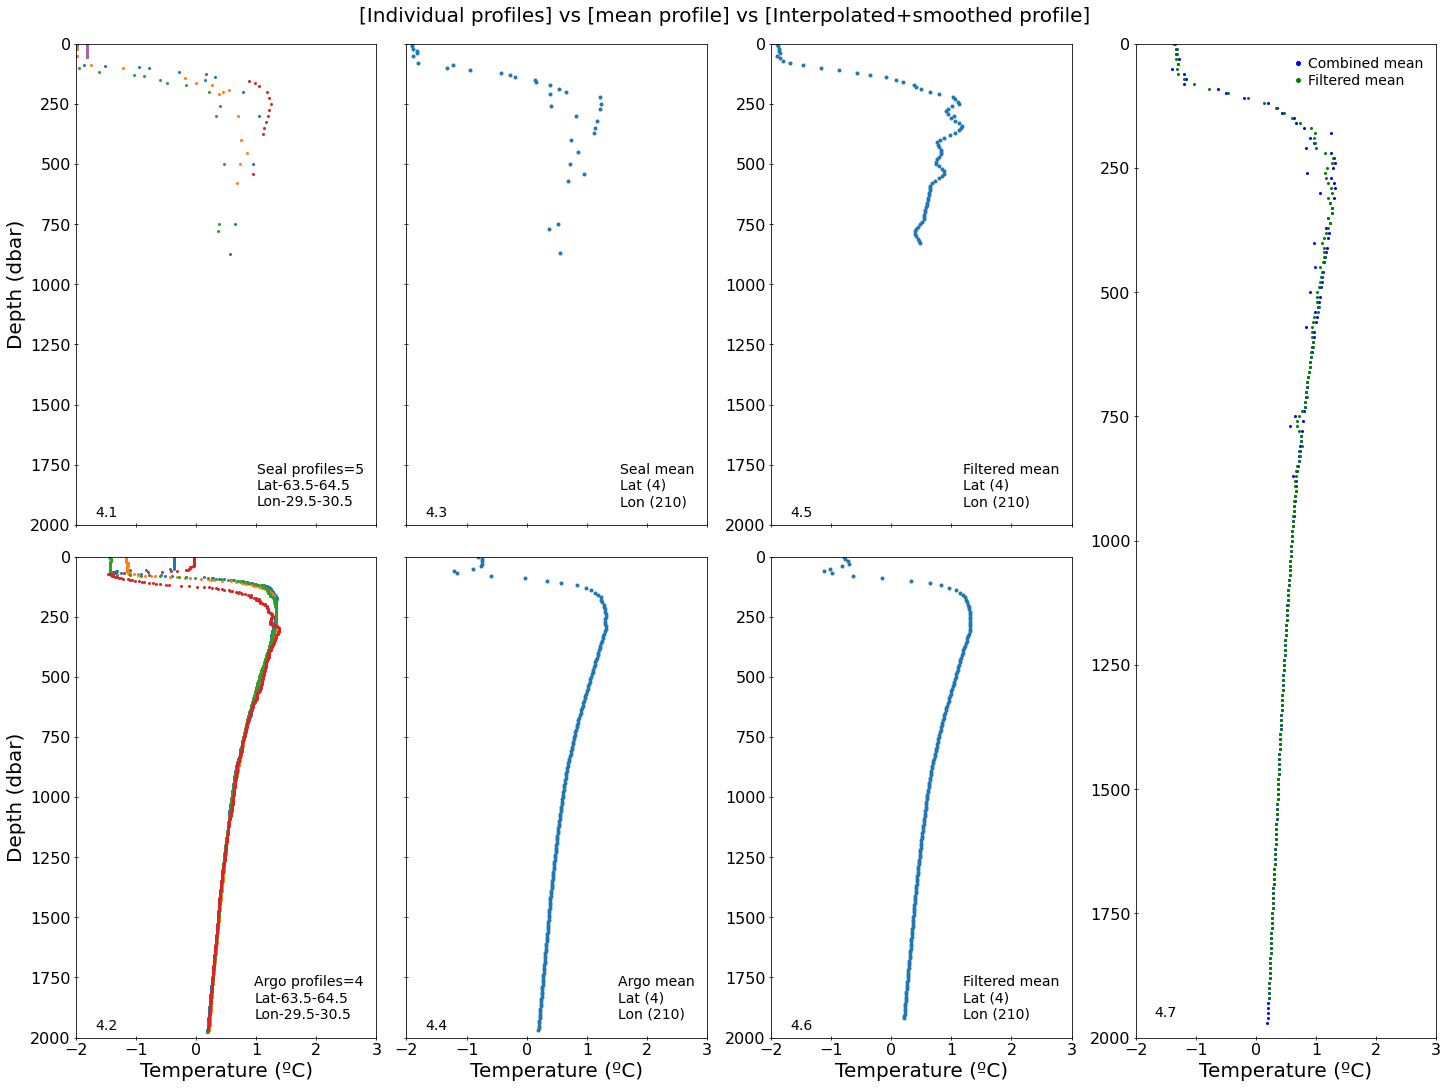

In [124]:
from scipy.interpolate import interp1d

# This subroutine plot Seal Vertical Profiles and the Mean Profile from the Grid System
# It is necessary to run the subroutine ...
#   where "argo_temp_grid_withdepth" or "argo_sal_grid_withdepth" is calculated
        
# Defining Geographycal Boundaries
lat_i = 63.5 ; lat_f = 64.5 ; # <-- 1º res ###   0.5º res --> lat_i = 63.25 ; lat_f = 63.75 ; 
# i = northermost # f = southermost 
lon_i = 29.5 ; lon_f = 30.5; # <-- 1º res ###   0.5º res --> #lon_i = 105.25 ; lon_f = 105.75; 
# i = westermost # f = eastermost 
# Grid system cell related to the geographycal boundaries
lat_grid = 4; lon_grid = 210;
# Maximum and minimum Temperature in the plot
t_max = 3; t_min = -2;
# Maximum and minimum Salinity in the plot
s_max = 36.; s_min = 33.;
# Maximum and minimum Temperature in the plot
p_max = 2000; p_min = 0;

# defining the "area of interest"
mask_seal = ((seal["lat"] < -lat_i) & (seal["lat"] > -lat_f) & (seal["lon"] > lon_i) & (seal["lon"] < lon_f))  
mask_argo = ((argo["lat"] < -lat_i) & (argo["lat"] > -lat_f) & (argo["lon"] > lon_i) & (argo["lon"] < lon_f)) 

# calculate the number of Argo and Seal profiles within the "area of interest" defined above
# In this case "np.flatnonzero" will return indices 
#    that are non-zero (or TRUE) in the flattened version of "mask_*"
n_seal_profiles = len(np.flatnonzero(mask_seal)) 
n_argo_profiles = len(np.flatnonzero(mask_argo))
print("seal", len(np.flatnonzero(mask_seal)),np.flatnonzero(mask_seal))
print("argo", len(np.flatnonzero(mask_argo)), np.flatnonzero(mask_argo))

depth = np.arange(p_min, p_max, 10)
xaxis = np.arange(t_min, t_max, 1)

fig = plt.figure(constrained_layout=True, figsize=(20,15))
gs = GridSpec(2, 4, figure=fig)

for i in np.flatnonzero(mask_seal):
    temp_seal = seal["temperature"][i] #sal_seal = seal["salinity"][i]
    pressure_seal = seal["pressure"][i]
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(temp_seal, pressure_seal,'.', markersize=4)
plt.legend(title='Seal profiles={}\nLat-{}-{}\nLon-{}-{}'.format(n_seal_profiles,lat_i, lat_f, lon_i, lon_f), loc='lower right', title_fontsize=fontsize)

for i in np.flatnonzero(mask_argo):
    temp_argo = argo["temperature"][i]
    pressure_argo = argo["pressure"][i]
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(temp_argo, pressure_argo,'.', markersize=4)
#ax3.set_title("Argo profiles".format(n_seal_profiles), fontsize="18") 
plt.legend(title='Argo profiles={}\nLat-{}-{}\nLon-{}-{}'.format(n_argo_profiles,lat_i, lat_f, lon_i, lon_f), loc='lower right', title_fontsize=fontsize)

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=6)
plt.legend(title='Seal mean\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), loc='lower right', title_fontsize=fontsize)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=6)
plt.legend(title='Argo mean\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), 
           loc='lower right', title_fontsize=fontsize)

interp_seal = interp_nans(seal_temp_grid_withdepth[:, lon_grid, :])
interp_argo = interp_nans(argo_temp_grid_withdepth[:, lon_grid, :])
#xsection_temp = interp_nans(xsection_temp)
#xsection_sal = argo_sal_grid_withdepth[:,a,:]

vprofile = pd.Series(seal_temp_grid_withdepth[lat_grid, lon_grid, :])
window=9; polyorder=3;
seal_mean_filtered_profile = vert_prof_filter(vprofile, window, polyorder)
ax5 = fig.add_subplot(gs[0, 2])
ax5.plot(seal_mean_filtered_profile[0,:], depth, '.',  markersize=6)#, label="smooth w11 p.order 5")#, color='blue') #Savitzky-Golay
plt.legend(title='Filtered mean\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), 
           loc='lower right', title_fontsize=fontsize)
#ax5.text(2.15, 250, "Grid cell\nLat ({})\nLon ({})".format(lat_grid,lon_grid), 
                 #va="center", ha="left", fontsize=fontsize, color='black')

vprofile = pd.Series(argo_temp_grid_withdepth[lat_grid, lon_grid, :])
window=11; polyorder=5;
argo_mean_filtered_profile = vert_prof_filter(vprofile, window, polyorder)    
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(argo_mean_filtered_profile[0,:], depth, '.', markersize=6)#, label='Argo interpolated')
plt.legend(title='Filtered mean\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), 
           loc='lower right', title_fontsize=fontsize)
    
vprofile = pd.Series(combined_temp_grid_withdepth[lat_grid, lon_grid, :])
window=11; polyorder=5;
combined_mean_filtered_profile = vert_prof_filter(vprofile, window, polyorder)
ax7 = fig.add_subplot(gs[:, 3])
ax7.plot(vprofile, depth, '.', markersize=4, color='blue',label='Combined mean')
ax7.plot(combined_mean_filtered_profile[0,:], depth, '.', color='green',markersize=4, 
         label='Filtered mean')
plt.legend(loc='upper right', title_fontsize=fontsize)

fig.suptitle("[Individual profiles] vs [mean profile] vs [Interpolated+smoothed profile]", fontsize="20")

format_axes_a(fig)

plt.show()

s 0     -1.353785
1     -1.325350
2     -1.322501
3     -1.279778
4     -1.288658
         ...   
195    0.204065
196    0.199905
197    0.191991
198         NaN
199         NaN
Length: 200, dtype: float64
s.shape (200,)
y_interp 0     -1.353785
1     -1.325350
2     -1.322501
3     -1.279778
4     -1.288658
         ...   
195    0.204065
196    0.199905
197    0.191991
198         NaN
199         NaN
Length: 200, dtype: float64
y_interp.shape (200,)
y_smooth (array([-1.34696885, -1.34589209, -1.30509853, -1.28578544, -1.29775892,
       -1.31675866, -1.29341384, -1.19543436, -1.02848347, -0.7784722 ,
       -0.46829487, -0.13459145,  0.14387186,  0.3375727 ,  0.46409792,
        0.59839127,  0.73990131,  0.92440221,  0.97915732,  0.97274867,
        0.9798644 ,  0.99446778,  1.15245385,  1.28674245,  1.25953973,
        1.1884019 ,  1.14379257,  1.16073901,  1.20554805,  1.25351141,
        1.26553754,  1.20885757,  1.2319533 ,  1.26145116,  1.26547042,
        1.20635349,  1.2392254

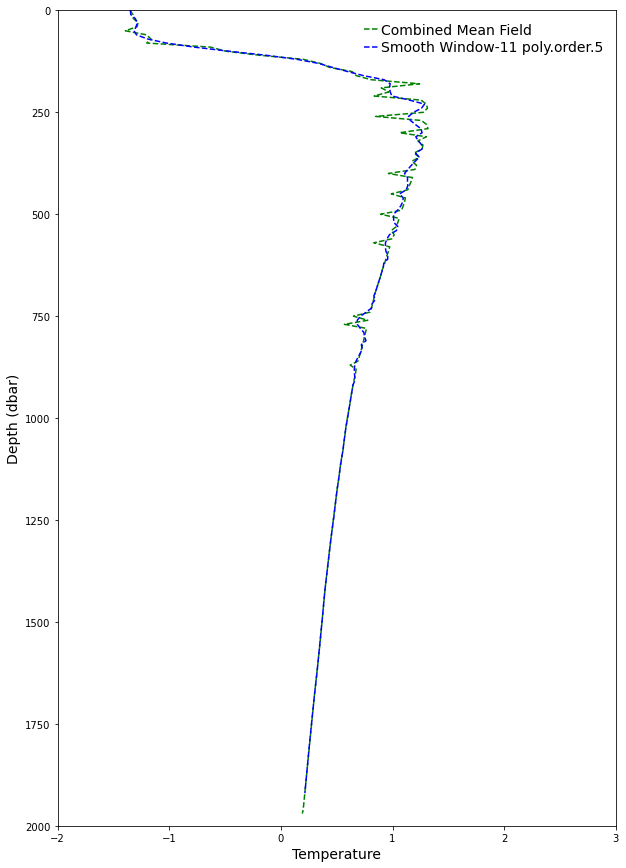

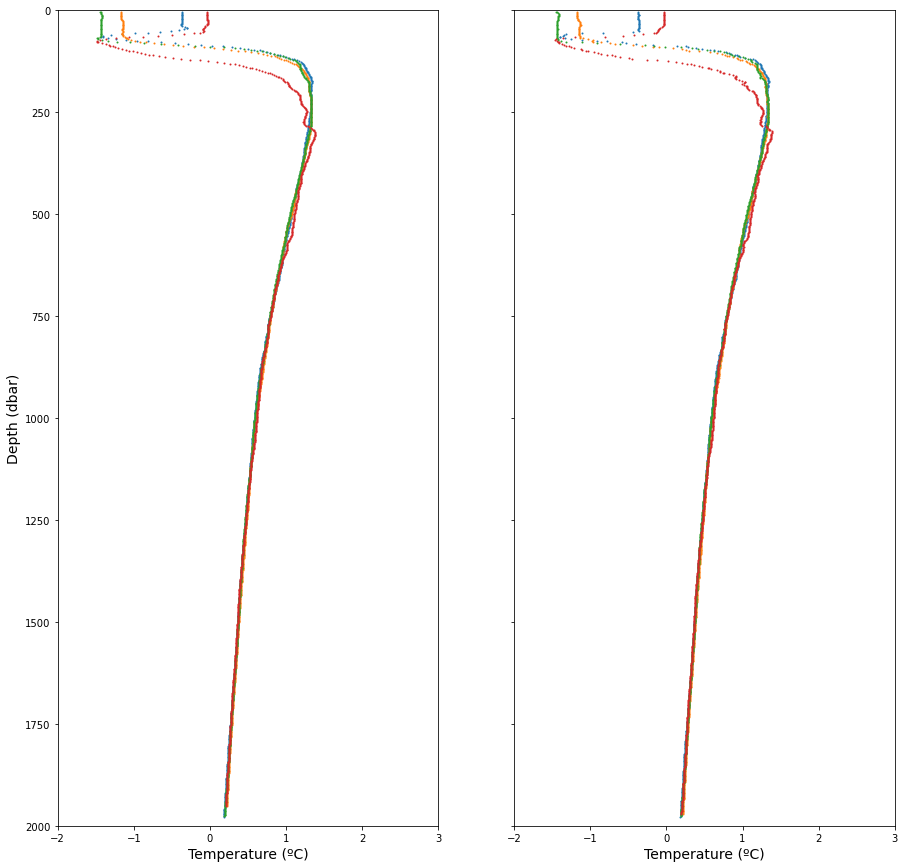

In [43]:
from scipy.interpolate import interp1d
from scipy import interpolate
from scipy import signal

s = pd.Series(combined_temp_grid_withdepth[lat_grid, lon_grid, :])
print("s",s)
print("s.shape",s.shape)
poly_order = 5
y_interp = s.interpolate(method='linear', limit= 200, limit_area="Inside")
print("y_interp",y_interp)
print("y_interp.shape",y_interp.shape)

y_smooth=signal.savgol_filter(s,
                           window_length=11, # window size used for filtering
                           polyorder=5, # order of fitted polynomial
                           mode='interp', # ‘mirror’, ‘constant’, ‘nearest’, ‘wrap’ or ‘interp’. This determines the type of extension to use for the padded signal to which the filter is applied.
                           cval=5), # Value to fill past the edges of the input if mode is ‘constant’. Default is 0.0.
print("y_smooth", y_smooth)
data_in_array = np.array(y_smooth)

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
ax.set_ylim(p_max, p_min); 
ax.set_xlim(t_min, t_max)
#ax.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, 'o', color='orange', markersize=2, label="Argo")
#ax.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, 'o', color='yellow', markersize=2, label="Seal")
ax.plot(combined_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '--', color='green', markersize=4, label="Combined Mean Field")
#ax.plot(y_interp, depth, '--', label="interp pol 3", color='mediumpurple')
ax.plot(data_in_array[0,:], depth, '--', label="Smooth Window-11 poly.order.5", color='blue') #Savitzky-Golay
ax.set_ylabel("Depth (dbar)", fontsize=fontsize)
ax.set_xlabel("Temperature", fontsize=fontsize)

plt.legend()
plt.show()


from scipy.signal import sosfiltfilt, butter
from scipy.signal import sosfilt, sosfilt_zi


#fig = plt.figure(figsize=(10,15))
#ax = fig.add_subplot(111)
sos = butter(2, 0.5, output='sos')
b, a = signal.butter(1, 0.75)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(15,15))


for i in np.flatnonzero(mask_argo):
    temp_argo = argo["temperature"][i]
    #sal_seal = seal["salinity"][i]
    pressure_argo = argo["pressure"][i]
    #yy = signal.filtfilt(b, a, temp_argo)
    #y = sosfiltfilt(sos, temp_argo)
    y_smooth=signal.savgol_filter(temp_argo,
                           window_length=21, # window size used for filtering
                           polyorder=5, # order of fitted polynomial
                           mode='nearest',
                           cval=5), # Value to fill past the edges of the input if mode is ‘constant’. Default is 0.0.
    data_in_array = np.array(y_smooth)    

    ax1.plot(data_in_array[0,:], pressure_argo, '.',  markersize=2, label="smooth w11 p.order 5")#, color='blue') #Savitzky-Golay
    ax2.plot(temp_argo, pressure_argo,'.', markersize=2)
#    ax.plot(y, pressure_argo, '--', label='y(t)')
#    ax.plot(yy, pressure_argo, 'k')
        
#ax1.plot(x, y)
#ax1.set_title('Sharing Y axis')
#ax2.scatter(x, y)

    
#ax.tick_params(axis="both", direction='inout', which='major', labelsize=16, labelbottom=True, labelleft=True)
ax1.set_ylim(p_max, p_min); 
ax1.set_xlim(t_min, t_max)
ax1.set_ylabel("Depth (dbar)", fontsize=fontsize)
ax1.set_xlabel("Temperature (ºC)", fontsize=fontsize)
ax2.set_xlabel("Temperature (ºC)", fontsize=fontsize)
    
#ax1.set_title("Seal profiles".format(n_seal_profiles), fontsize="18")
#plt.legend(title='Seal profiles={}\nLat-{}-{}\nLon-{}-{}'.format(n_seal_profiles,lat_i, lat_f, lon_i, lon_f), loc='upper right', title_fontsize=fontsize)
plt.show()


argo 325
test200 (325,)
argo -65.447 0.52 [cftime.DatetimeGregorian(2010-08-24 22:56:17)
 cftime.DatetimeGregorian(2010-12-12 01:12:37)
 cftime.DatetimeGregorian(2010-12-21 23:00:22) ...
 cftime.DatetimeGregorian(2019-04-03 09:36:22)
 cftime.DatetimeGregorian(2019-04-13 02:03:14)
 cftime.DatetimeGregorian(2019-04-22 18:23:48)]
argo -65.447 0.52 [cftime.DatetimeGregorian(2010-08-24 22:56:17)
 cftime.DatetimeGregorian(2010-12-12 01:12:37)
 cftime.DatetimeGregorian(2010-12-21 23:00:22) ...
 cftime.DatetimeGregorian(2019-04-03 09:36:22)
 cftime.DatetimeGregorian(2019-04-13 02:03:14)
 cftime.DatetimeGregorian(2019-04-22 18:23:48)]
argo -65.421 0.607 [cftime.DatetimeGregorian(2010-08-24 22:56:17)
 cftime.DatetimeGregorian(2010-12-12 01:12:37)
 cftime.DatetimeGregorian(2010-12-21 23:00:22) ...
 cftime.DatetimeGregorian(2019-04-03 09:36:22)
 cftime.DatetimeGregorian(2019-04-13 02:03:14)
 cftime.DatetimeGregorian(2019-04-22 18:23:48)]
argo -65.421 0.607 [cftime.DatetimeGregorian(2010-08-24 22:5

<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-77-330955c81d57>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(15, 200) (15, 200)


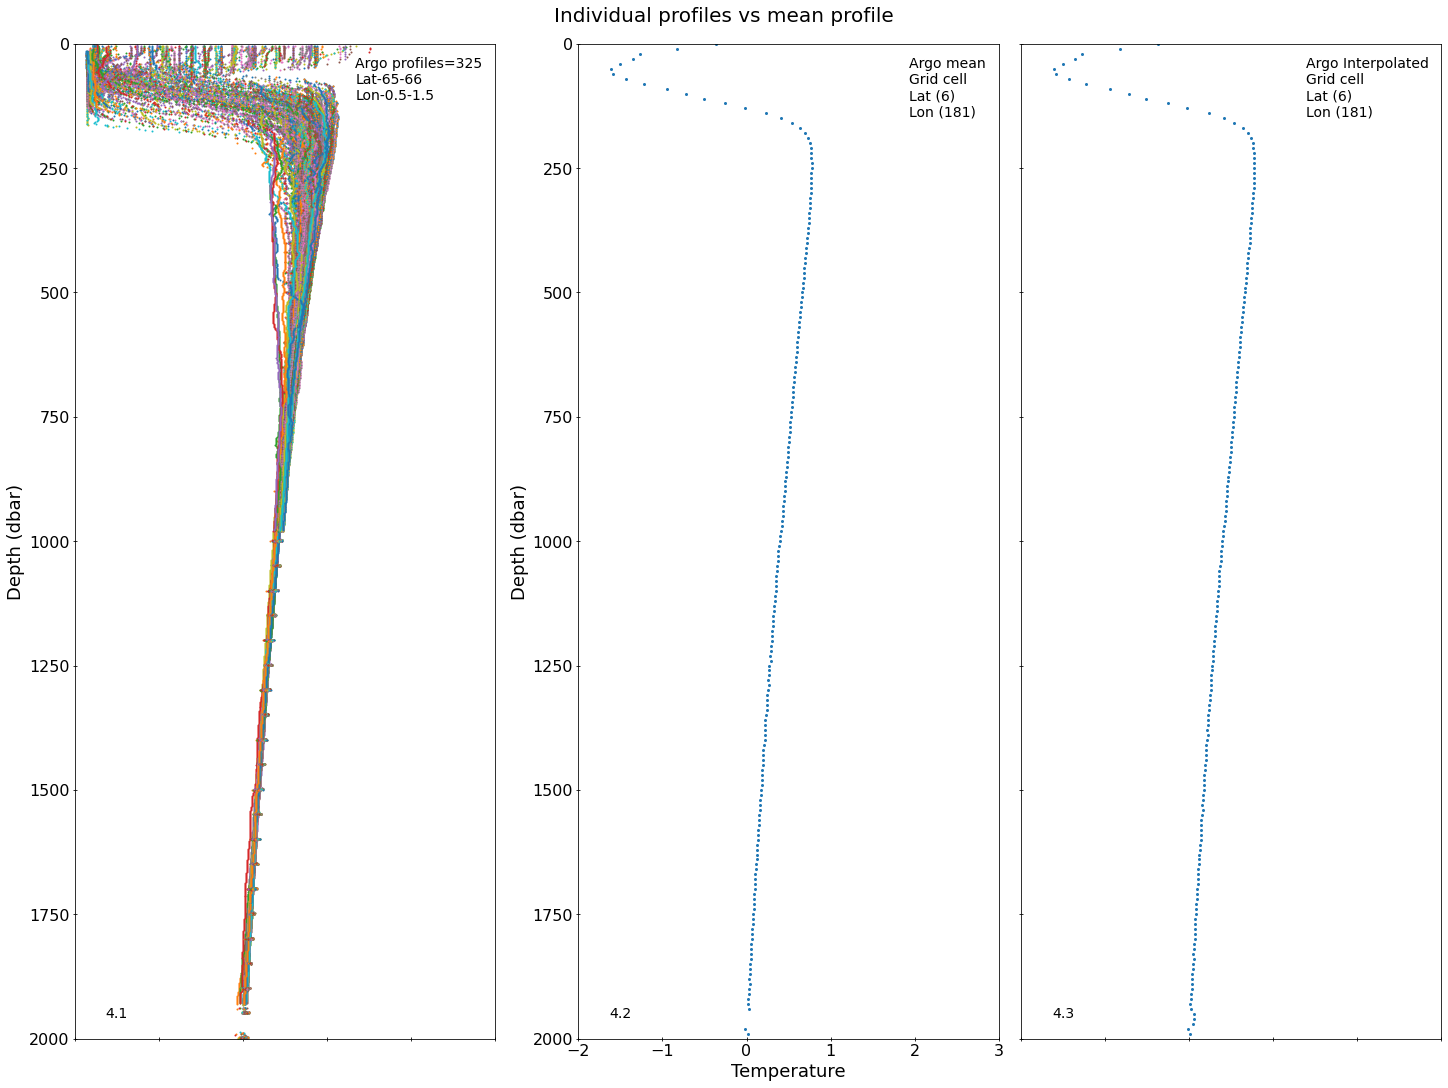

In [77]:
# This subroutine plot Seal Vertical Profiles and the Mean Profile from the Grid System
# It is necessary to run the subroutine ...
#   where "argo_temp_grid_withdepth" or "argo_sal_grid_withdepth" is calculated
        
fig = plt.figure(constrained_layout=True, figsize=(20,15))

gs = GridSpec(1, 3, figure=fig)

# Defining Geographycal Boundaries
lat_i = 65 ; lat_f = 66 ; # <-- 1º res ###   0.5º res --> lat_i = 63.25 ; lat_f = 63.75 ; 
# i = northermost # f = southermost 
lon_i = 0.5 ; lon_f = 1.5; # <-- 1º res ###   0.5º res --> #lon_i = 105.25 ; lon_f = 105.75; 
# i = westermost # f = eastermost 

# Grid system cell related to the geographycal boundaries
lat_grid = 6; lon_grid = 181;

# Maximum and minimum Temperature in the plot
t_max = 3; t_min = -2;
# Maximum and minimum Salinity in the plot
s_max = 36.; s_min = 33.;
# Maximum and minimum Temperature in the plot
p_max = 2000; p_min = 0;

fontsize = 14

# defining the "area of interest"

mask_argo = ((argo["lat"] < -lat_i) & (argo["lat"] > -lat_f) & (argo["lon"] > lon_i) & (argo["lon"] < lon_f)) 

# calculate the number of Argo and Seal profiles within the "area of interest" defined above
# In this case "np.flatnonzero" will return indices 
#    that are non-zero (or TRUE) in the flattened version of "mask_*"
n_argo_profiles = len(np.flatnonzero(mask_argo))

#print("argo", len(np.flatnonzero(mask_argo)), np.flatnonzero(mask_argo))
print("argo", len(np.flatnonzero(mask_argo)))
test200 = np.flatnonzero(mask_argo)
print("test200", test200.shape)
#print("test200", test200)

#for i in range(1, 5):

for i in np.flatnonzero(mask_argo):
    lat_mask = argo["lat"][i]
    lon_mask = argo["lon"][i]
    date_mask = argo["datetime"]
    #data_mask = np.datetime_as_string(date_mask, unit='s')
    #date_mask = date_mask.strftime("%Y-%m-%d %H:%M:%S.%f")
    #flatnz_argo = test200[i]
    print("argo", lat_mask, lon_mask, date_mask)
    #print("datetime", datetime.strftime("%Y-%m-%d %H:%M:%S.%f"))    

depth = np.arange(p_min, p_max, 10)
xaxis = np.arange(t_min, t_max, 1)


for i in np.flatnonzero(mask_argo):
    temp_argo = argo["temperature"][i]
    pressure_argo = argo["pressure"][i]
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(temp_argo, pressure_argo,'.', markersize=2)
#ax3.set_title("Argo profiles".format(n_seal_profiles), fontsize="18") 
plt.legend(title='Argo profiles={}\nLat-{}-{}\nLon-{}-{}'.format(n_argo_profiles,lat_i, lat_f, lon_i, lon_f), loc='upper right', title_fontsize=fontsize)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
plt.legend(title='Argo mean\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), 
           loc='upper right', title_fontsize=fontsize)



interp_argo = interp_nans(argo_temp_grid_withdepth[:, lon_grid, :])
print(interp_argo.shape, interp_seal.shape)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(interp_argo[lat_grid, :], depth, '.', markersize=4)#, label='Argo interpolated')
plt.legend(title='Argo Interpolated\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), 
           loc='upper right', title_fontsize=fontsize)
#ax6.text(2.15, 250, "Grid cell\nLat ({})\nLon ({})".format(lat_grid,lon_grid), 
                 #va="center", ha="left", fontsize=fontsize, color='black')

#fig.suptitle('Boundaries: Lat (-{})-(-{}) - Lon ({})-({})\nCel grid: Lat (-{}) - Lon ({})'.format(lat_i,lat_f,lon_i,lon_f,lat_grid, lon_grid), fontsize="18")
fig.suptitle("Individual profiles vs mean profile", fontsize="20")

format_axes_a(fig)

plt.show()

<ipython-input-78-2bb285e1e47a>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-78-2bb285e1e47a>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(gs[0, 0])
<ipython-input-78-2bb285e1e47a>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance wil

seal 5 [74147 74148 74149 98835 98836]
argo 4 [62105 62107 62108 62110]


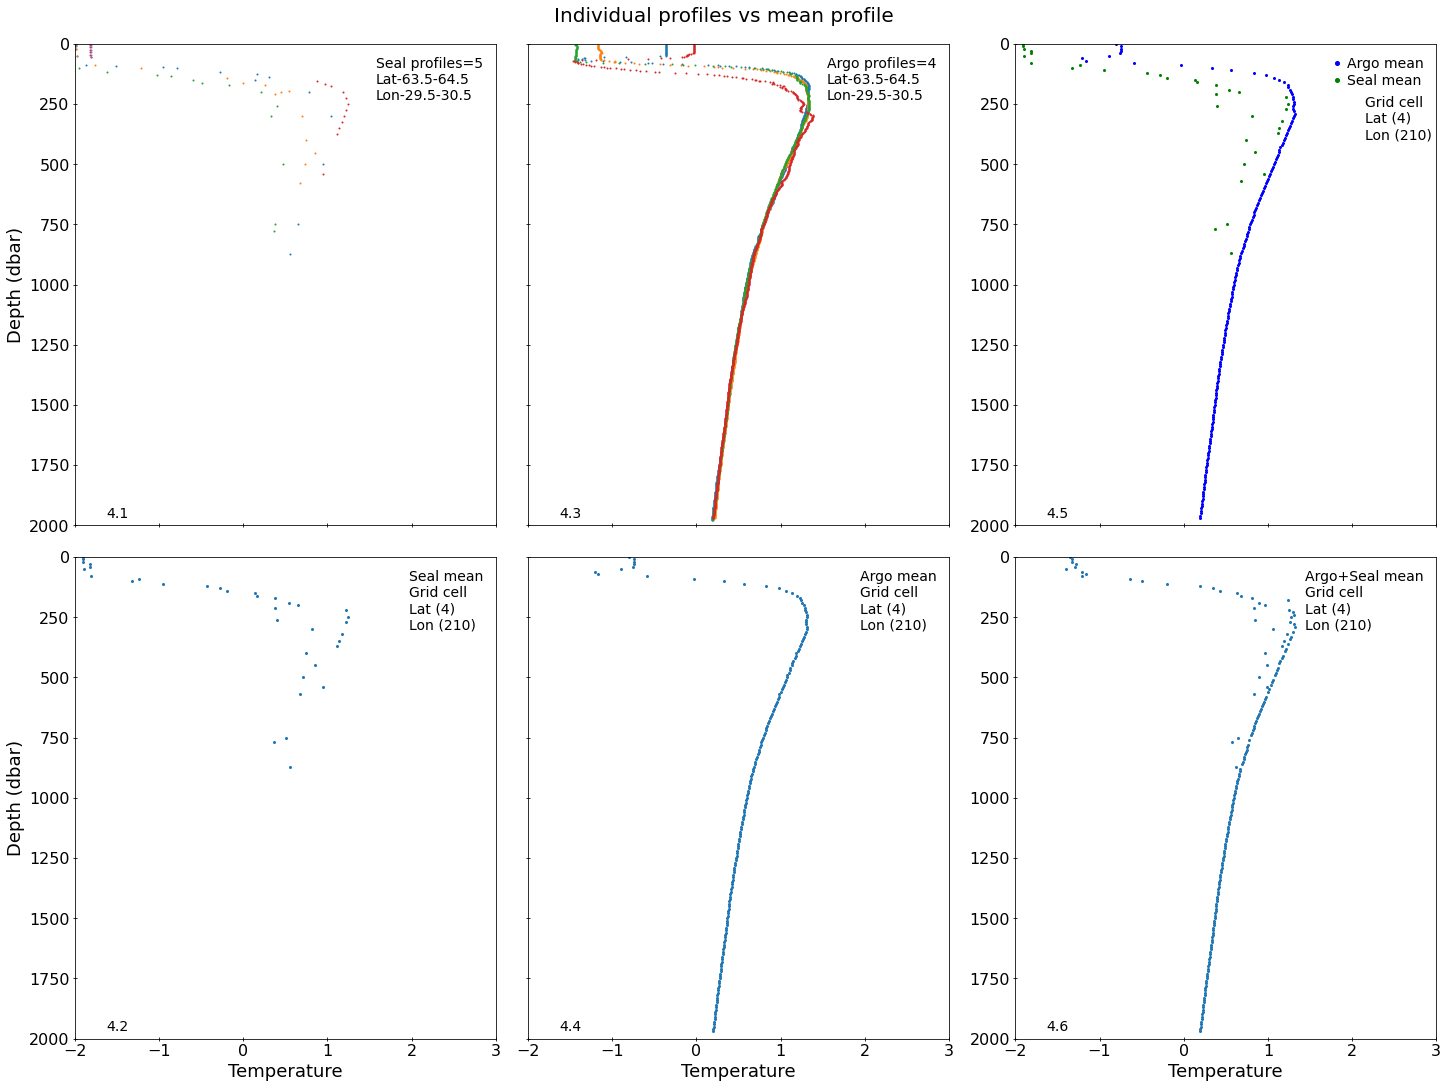

In [78]:
# This subroutine plot Seal Vertical Profiles and the Mean Profile from the Grid System
# It is necessary to run the subroutine ...
#   where "argo_temp_grid_withdepth" or "argo_sal_grid_withdepth" is calculated
        
fig = plt.figure(constrained_layout=True, figsize=(20,15))

gs = GridSpec(2, 3, figure=fig)

# Defining Geographycal Boundaries
lat_i = 63.5 ; lat_f = 64.5 ; # <-- 1º res ###   0.5º res --> lat_i = 63.25 ; lat_f = 63.75 ; 
# i = northermost # f = southermost 
lon_i = 29.5 ; lon_f = 30.5; # <-- 1º res ###   0.5º res --> #lon_i = 105.25 ; lon_f = 105.75; 
# i = westermost # f = eastermost 

# Grid system cell related to the geographycal boundaries
lat_grid = 4; lon_grid = 210;

# Maximum and minimum Temperature in the plot
t_max = 3; t_min = -2;
# Maximum and minimum Salinity in the plot
s_max = 36.; s_min = 33.;
# Maximum and minimum Temperature in the plot
p_max = 2000; p_min = 0;

fontsize = 14

# defining the "area of interest"
mask_seal = ((seal["lat"] < -lat_i) & (seal["lat"] > -lat_f) & (seal["lon"] > lon_i) & (seal["lon"] < lon_f))  
mask_argo = ((argo["lat"] < -lat_i) & (argo["lat"] > -lat_f) & (argo["lon"] > lon_i) & (argo["lon"] < lon_f)) 

# calculate the number of Argo and Seal profiles within the "area of interest" defined above
# In this case "np.flatnonzero" will return indices 
#    that are non-zero (or TRUE) in the flattened version of "mask_*"
n_seal_profiles = len(np.flatnonzero(mask_seal)) 
n_argo_profiles = len(np.flatnonzero(mask_argo))
print("seal", len(np.flatnonzero(mask_seal)),np.flatnonzero(mask_seal))
print("argo", len(np.flatnonzero(mask_argo)), np.flatnonzero(mask_argo))

depth = np.arange(p_min, p_max, 10)
xaxis = np.arange(t_min, t_max, 1)

for i in np.flatnonzero(mask_seal):
    temp_seal = seal["temperature"][i]
    #sal_seal = seal["salinity"][i]
    pressure_seal = seal["pressure"][i]
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(temp_seal, pressure_seal,'.', markersize=2)
#ax1.set_title("Seal profiles".format(n_seal_profiles), fontsize="18")
plt.legend(title='Seal profiles={}\nLat-{}-{}\nLon-{}-{}'.format(n_seal_profiles,lat_i, lat_f, lon_i, lon_f), loc='upper right', title_fontsize=fontsize)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
plt.legend(title='Seal mean\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), loc='upper right', title_fontsize=fontsize)

for i in np.flatnonzero(mask_argo):
    temp_argo = argo["temperature"][i]
    pressure_argo = argo["pressure"][i]
    ax3 = fig.add_subplot(gs[0, 1])
    ax3.plot(temp_argo, pressure_argo,'.', markersize=2)
#ax3.set_title("Argo profiles".format(n_seal_profiles), fontsize="18") 
plt.legend(title='Argo profiles={}\nLat-{}-{}\nLon-{}-{}'.format(n_argo_profiles,lat_i, lat_f, lon_i, lon_f), loc='upper right', title_fontsize=fontsize)

ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
plt.legend(title='Argo mean\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), loc='upper right', title_fontsize=fontsize)

ax5 = fig.add_subplot(gs[0, 2])
ax5.plot(argo_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.b', markersize=4, label='Argo mean')
ax5.plot(seal_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.g', markersize=4, label='Seal mean')
plt.legend(loc='upper right', title_fontsize=fontsize)
ax5.text(2.15, 310, "Grid cell\nLat ({})\nLon ({})".format(lat_grid,lon_grid), 
                 va="center", ha="left", fontsize=fontsize, color='black')

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(combined_temp_grid_withdepth[lat_grid, lon_grid, :], depth, '.', markersize=4)
plt.legend(title='Argo+Seal mean\nGrid cell\nLat ({})\nLon ({})'.format(lat_grid,lon_grid), 
           loc='upper right', title_fontsize=fontsize)

#fig.suptitle('Boundaries: Lat (-{})-(-{}) - Lon ({})-({})\nCel grid: Lat (-{}) - Lon ({})'.format(lat_i,lat_f,lon_i,lon_f,lat_grid, lon_grid), fontsize="18")
fig.suptitle("Individual profiles vs mean profile", fontsize="20")

format_axes_a(fig)

plt.show()

In [9]:
def load_netcdf_grid(path = "Argo_South_60", resolution = 1, target_var = "temp", 
                     with_depth = False, filter_month = None, filter_season = None, 
                     filter_start = datetime(2000,1,1), filter_end = datetime(2021,1,1)):
    if with_depth:
        grid = np.full(shape=[15 * resolution, 360 * resolution, 200], fill_value=np.nan)
        gridcounts = np.zeros(shape=[15 * resolution, 360 * resolution, 200])
    else:
        grid = np.full(shape=[15 * resolution, 360 * resolution], fill_value=np.nan)
    files = glob.glob("data/{}/**/*.nc".format(path), recursive=True)
    #1 glob.glob - returns a list of all the files in a given folder with the extension 'nc'
    #2 recursive=true - keeps on looking for all the files till the end, or the last file that exist
    
    
    # creating lists
    filename2 = []
    nbprof2 = [] 
    filename2_maskout = []
    ## End of "creating lists"
    
    for f in tqdm(files[:]):
    # tqdm - make your loops show a progress meter
        d = Dataset(f)
        #1 DATASET - Creating/Opening/Closing a netCDF file. 
        # This is the method used to open an existing netCDF file.
        lat = d.variables["LATITUDE"][:]
        #mask = (lat < -60) & (lat > -74.75)
        mask = (lat < -60) & (lat > -74.5)
        
        # Counting number of profiles per NetCDF files
        nbprof = [len(lat)] # number of profiles per file
        nbprof2.extend(nbprof)
        # filename = filename
        filename = ["Filename {}".format(f)]
        filename2.extend(filename)
        #Create a DataFrame: filename + number of profiles per file    
        profiles_per_files = {'Filename': filename2, 'Number of profiles per file': nbprof2}
        new_df = pd.DataFrame(data=profiles_per_files)
        #Save "new_df" as csv file:  
        new_df.to_csv('filename_nbprof.csv', index=False)
        ## End of "Counting number of profiles per NetCDF files"
        
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        dates = num2date(juld, units, "standard")
        datemask = (dates > filter_start) & (dates < filter_end)
        mask &= datemask
        if filter_month:
            datemask = np.array([d.month == filter_month for d in dates])
            mask &= datemask
        if filter_season:
            if filter_season == "Summer":
                datemask = np.array([d.month >= 10 or d.month <= 3 for d in dates])
            elif filter_season == "Winter":
                datemask = np.array([d.month > 3 and d.month < 10 for d in dates])
            mask &= datemask
        if any(mask):
            lat = np.round((np.abs(lat[mask]) - 60) * resolution).astype(int)
            lon = d.variables["LONGITUDE"][mask]
            testando5000 = lon
            lon = np.round((lon + 180) * resolution).astype(int)
            #print(lon[0:3],testando5000[0:3])
            lon[lon == 360 * resolution] = 0
            if with_depth:
                #pres = np.round(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                pres = np.floor(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                temp = d.variables["TEMP_ADJUSTED"][mask]
                if target_var == "sal":
                    try:
                        sal = d.variables["PSAL_ADJUSTED"][mask]
                    except:
                        print("No salinity for {}".format(f))
                        continue
            else:
                pres = d.variables["PRES_ADJUSTED"][mask]
                temp = d.variables["TEMP_ADJUSTED"][mask, 0]
            for x in np.unique(lon):
                for y in np.unique(lat):
                    if with_depth:
                        ptmask = (lon == x) & (lat == y)
                        for z in np.unique(pres[ptmask]):
                            if z>= 200 or np.ma.is_masked(z):
                                continue
                            depthmask = pres[ptmask] == z
                            if target_var == "temp":
                                values_at_pt = temp[ptmask][depthmask].compressed()
                            elif target_var == "sal":
                                values_at_pt = sal[ptmask][depthmask].compressed()
                            grid[y, x, z] = np.nansum((grid[y,x,z], np.nansum(values_at_pt)))
                            gridcounts[y, x, z] += len(values_at_pt)
                    else:
                        ptmask = (lon == x) & (lat == y)
                        if target_var == "n_point":
                            v = np.sum(ptmask)
                            if not np.ma.is_masked(v):
                                if v != 0:                                   
                                #1 added a if statement checking if number of points is greater than 0
                                    grid[y, x] = np.nansum((grid[y, x], v))
                        elif target_var == "temp":
                            temps_at_pt = temp[ptmask]
                            v = np.ma.mean(temps_at_pt)
                            # 1 MEAN - numpy.ma.mean(self, axis=None, dtype=None, out=None, keepdims=<no value>) 
                            #  Returns the average of the array elements along given axis.
                            #  Masked entries are ignored, and result elements which are not finite 
                            #  will be masked.
                            if not np.ma.is_masked(v):
                                grid[y, x] = np.nanmean((grid[y, x], v))
                        elif target_var == "depth":
                            pres_at_pt = pres[ptmask]
                            if len(pres_at_pt):
                                v = np.ma.max(pres[ptmask])
                                if not np.ma.is_masked(v):
                                    grid[y, x] = np.nanmax((grid[y, x], v))
    if with_depth:
        grid /= gridcounts
        print(np.nanmin(grid), np.nanstd(grid), np.nanmax(grid))
    return grid

# This version seems a lot more inefficient for some reason
def load_netcdf_grid_new(platform = "argo", resolution = 1, target_var = "temp", filter_month = None, filter_season = None, filter_start = datetime(2000,1,1), filter_end = datetime(2020,1,1)):
    grid = np.full(shape=[15 * resolution, 360 * resolution, 200], fill_value=np.nan)
             
    if platform == "argo":
        data = argo
    else:
        data = seal
    mask = (data["lat"] < -60) & (data["lat"] > -75) #mask = (data["lat"] < -60) & (data["lat"] > -74.5)
    datemask = (data["datetime"] > filter_start) & (data["datetime"] < filter_end)
    mask &= datemask
    if filter_month:
        datemask = np.array([d.month == filter_month for d in data["datetime"]])
        mask &= datemask
    if filter_season:
        if filter_season == "Summer":
            datemask = np.array([d.month >= 10 or d.month <= 3 for d in data["datetime"]])
        elif filter_season == "Winter":
            datemask = np.array([d.month > 3 and d.month < 10 for d in data["datetime"]])
        mask &= datemask
    if any(mask):
        lat = np.round((np.abs(data["lat"][mask]) - 60) * resolution).astype(int)
        lon = data["lon"][mask]
        lon = np.round((lon + 180) * resolution).astype(int)
        lon[lon == 360 * resolution] = 0
        for y in tqdm(np.unique(lat)):
            for x in tqdm(np.unique(lon)):
                ptmask = (lon == x) & (lat == y)
                depths = set()
                for pres in data["pressure"][mask][ptmask]:
                    print(np.floor(pres / 10).compressed().astype(int))
                    depths.update(np.floor(pres / 10).compressed().astype(int))
                print(len(depths))
                for z in tqdm(depths):
                    depthmask = [np.floor(pres / 10) == z for pres in data["pressure"][mask][ptmask]]
                    values = []
                    for i in range(len(depthmask)):
                        values.extend(data["temperature"][mask][ptmask][i][depthmask[i]])
                    #print(values)
                    grid[y, x, z] = np.ma.mean(values)
    return grid

def plot_grid(grid, resolution = 1, title="title", cmap="nipy_spectral", cbtitle="Temperature °C", vmin=None, vmax=None):
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, -80, -5))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    #plt.title("{}".format(title, 1/resolution),fontsize = 16)
    #plt.title("\n{} at {}° resolution".format(title, 1/resolution),fontsize = 16)

    x = np.arange(-180, 180.1, 1/resolution)
    y = np.arange(-60, -75.1, 1/-resolution)
    x, y = np.meshgrid(x, y)
    x, y = m(x, y)
    
    if cbtitle=="Number of profiles":
        pcm = m.pcolormesh(x, y, grid, cmap=cmap, 
                    norm=colors.LogNorm(vmin, vmax))
   #                 #norm=colors.PowerNorm(gamma=0.25))
    #    print("vmin",vmin,"vmax",vmax)
        #ax.xaxis.grid(True, which='major')
        cb = plt.colorbar(pcm, extend='max',shrink=0.785, pad=0.05 , orientation="horizontal")
        #cb.locator=ticker.LogLocator(base=2)
        #cb.set_ticks(cbticks)
        #cb.update_ticks()
        cb.set_label(cbtitle, labelpad= 10, rotation=0, fontsize = 14)
        
    else:
        m.pcolormesh(x, y, grid, cmap=cmap, vmin=vmin, vmax=vmax)  #"colorcet" "nipy_spectral" "ocean" "gist_ncar" "cubehelix" "jet" "PuOr" "RdBu" "rainbow"
    #m.pcolormesh(x, y, grid, cmap=cmap, vmin=vmin, vmax=vmax)  #"colorcet" "nipy_spectral" "ocean" "gist_ncar" "cubehelix" "jet" "PuOr" "RdBu" "rainbow"
        cb = plt.colorbar(shrink=0.785, pad=0.05 , orientation="horizontal")
        cb.set_label(cbtitle, labelpad= 10, rotation=0, fontsize = 14)
    
    #m.pcolormesh(x, y, grid, cmap="jet", vmin=vmin, vmax=vmax)    
    plt.show()
    
def interp_nans(grid, method='linear'):
    x = np.arange(0, grid.shape[1])
    y = np.arange(0, grid.shape[0])
    mask = np.isnan(grid)
    xx, yy = np.meshgrid(x, y)
    x1 = xx[~mask]
    y1 = yy[~mask]
    newarr = grid[~mask]
    interp = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method=method)
    if method == "linear":
        interp = interp_nans(interp, "nearest")
    return interp

In [10]:
def load_netcdf_grid_sd(path = "Argo_South_60", resolution = 1, target_var = "temp", 
                     with_depth = False, filter_month = None, filter_season = None, 
                     filter_start = datetime(2000,1,1), filter_end = datetime(2021,1,1)):
    if with_depth:
        grid = np.full(shape=[15 * resolution, 360 * resolution, 200], fill_value=np.nan)
        gridcounts = np.zeros(shape=[15 * resolution, 360 * resolution, 200])
    else:
        grid = np.full(shape=[15 * resolution, 360 * resolution], fill_value=np.nan)
    files = glob.glob("data/{}/**/*.nc".format(path), recursive=True)
    #1 glob.glob - returns a list of all the files in a given folder with the extension 'nc'
    #2 recursive=true - keeps on looking for all the files till the end, or the last file that exist
    
    
    # creating lists
    filename2 = []
    nbprof2 = [] 
    filename2_maskout = []
    ## End of "creating lists"
    
    for f in tqdm(files[:]):
    # tqdm - make your loops show a progress meter
        d = Dataset(f)
        #1 DATASET - Creating/Opening/Closing a netCDF file. 
        # This is the method used to open an existing netCDF file.
        lat = d.variables["LATITUDE"][:]
        #mask = (lat < -60) & (lat > -74.75)
        mask = (lat < -60) & (lat > -74.5)
        
        # Counting number of profiles per NetCDF files
        nbprof = [len(lat)] # number of profiles per file
        nbprof2.extend(nbprof)
        # filename = filename
        filename = ["Filename {}".format(f)]
        filename2.extend(filename)
        #Create a DataFrame: filename + number of profiles per file    
        profiles_per_files = {'Filename': filename2, 'Number of profiles per file': nbprof2}
        new_df = pd.DataFrame(data=profiles_per_files)
        #Save "new_df" as csv file:  
        new_df.to_csv('filename_nbprof.csv', index=False)
        ## End of "Counting number of profiles per NetCDF files"
        
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        dates = num2date(juld, units, "standard")
        datemask = (dates > filter_start) & (dates < filter_end)
        mask &= datemask
        if filter_month:
            datemask = np.array([d.month == filter_month for d in dates])
            mask &= datemask
        if filter_season:
            if filter_season == "Summer":
                datemask = np.array([d.month >= 10 or d.month <= 3 for d in dates])
            elif filter_season == "Winter":
                datemask = np.array([d.month > 3 and d.month < 10 for d in dates])
            mask &= datemask
        if any(mask):
            lat = np.round((np.abs(lat[mask]) - 60) * resolution).astype(int)
            lon = d.variables["LONGITUDE"][mask]
            testando5000 = lon
            lon = np.round((lon + 180) * resolution).astype(int)
            #print(lon[0:3],testando5000[0:3])
            lon[lon == 360 * resolution] = 0
            if with_depth:
                #pres = np.round(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                pres = np.floor(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
                temp = d.variables["TEMP_ADJUSTED"][mask]
                if target_var == "sal":
                    try:
                        sal = d.variables["PSAL_ADJUSTED"][mask]
                    except:
                        print("No salinity for {}".format(f))
                        continue
            else:
                pres = d.variables["PRES_ADJUSTED"][mask]
                temp = d.variables["TEMP_ADJUSTED"][mask, 0]
            for x in np.unique(lon):
                for y in np.unique(lat):
                    if with_depth:
                        ptmask = (lon == x) & (lat == y)
                        for z in np.unique(pres[ptmask]):
                            if z>= 200 or np.ma.is_masked(z):
                                continue
                            depthmask = pres[ptmask] == z
                            if target_var == "temp":
                                values_at_pt = temp[ptmask][depthmask].compressed()
                            elif target_var == "sal":
                                values_at_pt = sal[ptmask][depthmask].compressed()
                            grid[y, x, z] = np.nansum((grid[y,x,z], np.nansum(values_at_pt)))
                            gridcounts[y, x, z] += len(values_at_pt)
                    else:
                        ptmask = (lon == x) & (lat == y)
                        if target_var == "n_point":
                            v = np.sum(ptmask)
                            if not np.ma.is_masked(v):
                                if v != 0:                                   
                                #1 added a if statement checking if number of points is greater than 0
                                    grid[y, x] = np.nansum((grid[y, x], v))
                        elif target_var == "temp":
                            temps_at_pt = temp[ptmask]
                            #v = np.ma.mean(temps_at_pt)
                            v = np.ma.std(temps_at_pt)
                            # 1 Standard deviation - numpy.ma.std(self, axis=None, dtype=None, out=None, ddof=0)
                            #  Compute the SD along the specified axis.
                            #  Returns the SD, a measure of the spread of a distribution, of the array elements. 
                            #  The SD is computed for the flattened array by default, otherwise over the specified axis.
                            if not np.ma.is_masked(v):
                                #grid[y, x] = np.nanmean((grid[y, x], v))
                                grid[y, x] = np.nanstd((grid[y, x], v))
                        elif target_var == "depth":
                            pres_at_pt = pres[ptmask]
                            if len(pres_at_pt):
                                v = np.ma.max(pres[ptmask])
                                if not np.ma.is_masked(v):
                                    grid[y, x] = np.nanmax((grid[y, x], v))
    if with_depth:
        grid /= gridcounts
        print(np.nanmin(grid), np.nanstd(grid), np.nanmax(grid))
    return grid


In [11]:
# Titles and labels for figures
a_title = "Argo Data"
s_title = "Seal Data"
comb_title = "Argo+Seal Data"
interp_title = "Interpolated Argo+Seal Data"
msf = "Salinity mean field "
mtf = "Temperature mean field "
msd = "Density mean field "
T_title = "Temperature"
S_title = "Salinity"
D_title = "Density"

# Maximum and Minimum - temperature and Salinity
smax = 34.8
smin = 32.5
tmax = 7
tmin = -2.5
rhomin = 1028
rhomax = 1026.5
# Grid Resolution
resolution = 1

In [ ]:
argo_pt_grid = load_netcdf_grid(target_var="n_point", with_depth = False, resolution = resolution)
seal_pt_grid = load_netcdf_grid(path="seal", target_var="n_point", with_depth = False, resolution = resolution)

In [ ]:
combined_pt_grid = np.nansum((argo_pt_grid, seal_pt_grid), axis=0)
combined_pt_grid[np.isnan(argo_pt_grid) & np.isnan(seal_pt_grid)] = np.nan
print(argo_pt_grid.shape,seal_pt_grid.shape,combined_pt_grid.shape)

In [ ]:
xx2 = np.nanmin(seal_pt_grid),np.nanmax(seal_pt_grid); print("xx2",xx2)
xx4 = np.log2(xx2); print("xx4",xx4)
xx6 = np.floor(xx4); print("xx6",xx6)
#xx7 = np.ceil(xx6); print(xx7)
lev_exp = np.arange(np.floor(np.log2(np.nanmin(seal_pt_grid))),
                   np.ceil(np.log2(np.nanmax(seal_pt_grid))+1))
print("lev_exp",lev_exp)
levs = np.power(2, lev_exp)
print("levs=", levs)
print("levs min and max",levs.min(),levs.max())

tickList = []
for i in range(0,len(lev_exp)): 
    value = float(levs[i])
    tickList.append(value)

print("Float Levs [i]",tickList)

In [ ]:
#plot_grid(argo_pt_grid, title=a_title + "\nNumber of vertical profiles", cmap="jet", cbtitle="Number of profiles", vmin=1,vmax=80, resolution = resolution)
#plot_grid(seal_pt_grid, title=s_title + "\nNumber of vertical profiles", cmap="jet", cbtitle="Number of profiles", vmin=1,vmax=100, resolution = resolution)
#plot_grid(combined_pt_grid, title=comb_title + "\nNumber of vertical profiles", cmap="jet", cbtitle="Number of profiles", vmin=1,vmax=100, resolution = resolution)

import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib.colors import SymLogNorm, LogNorm

plot_grid(argo_pt_grid, cmap="jet",
          cbtitle="Number of profiles", vmin=np.floor(np.nanmin(argo_pt_grid)),
          vmax=np.ceil(np.nanmax(argo_pt_grid)),resolution = resolution)

plot_grid(seal_pt_grid, cmap="jet",
          cbtitle="Number of profiles", vmin=np.floor(np.nanmin(seal_pt_grid)),
          vmax=np.nanmax(seal_pt_grid), resolution = resolution)

In [ ]:
print(len(argo_temp_grid_anew))
print(argo_temp_grid_anew[0].shape,argo_temp_grid_anew[1].shape)
print(argo_temp_grid_anew.shape)

In [12]:
argo_temp_grid = load_netcdf_grid(resolution = resolution)
seal_temp_grid = load_netcdf_grid("seal", resolution = resolution)
print(len(argo_temp_grid))
print(argo_temp_grid.shape,seal_temp_grid.shape)

<ipython-input-9-36afdc496723>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm(files[:]):


c:\users\fvie285\appdata\local\programs\python\python38\lib\site-packages\numpy\ma\core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
c:\users\fvie285\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-9-36afdc496723>:106: RuntimeWarning: Mean of empty slice
  grid[y, x] = np.nanmean((grid[y, x], v))



15
(15, 360) (15, 360)


In [ ]:
print(len(argo_temp_grid))
print(argo_temp_grid.shape,seal_temp_grid.shape)
print(len(argo_temp_grid))
print(argo_temp_grid[0].shape,argo_temp_grid[1].shape)

In [13]:
combined_temp_grid = np.nanmean((argo_temp_grid, seal_temp_grid), axis=0)
print(combined_temp_grid.shape)

(15, 360)


<ipython-input-13-e15be8551138>:1: RuntimeWarning: Mean of empty slice
  combined_temp_grid = np.nanmean((argo_temp_grid, seal_temp_grid), axis=0)


In [ ]:
#title = "Seal data gridded at {}\n0-10 decibar mean temperature\nMean across all points = {}".format(1/resolution,sealmean)
title = a_title + "\n0-10 decibars" + mtf
plot_grid(argo_temp_grid, title=title, resolution = resolution)
title = s_title + "\n0-10 decibar" + mtf
plot_grid(seal_temp_grid, title=title, resolution = resolution)
title = comb_title + "\n0-10 decibar" + mtf
plot_grid(combined_temp_grid, title=title, resolution = resolution)

In [14]:
interp = interp_nans(combined_temp_grid)

In [ ]:
#title = "Argo+Seal data gridded at {}\n0-10 decibar mean temperature\nMean across all points = {}".format(1/resolution,interpmean)
title = interp_title + "\n0-10 decibar" + mtf
plot_grid(interp, resolution = resolution, title=title)

In [ ]:
argo_max_depth = load_netcdf_grid(target_var = "depth", resolution = resolution)
seal_max_depth = load_netcdf_grid("seal", target_var = "depth", resolution = resolution)

In [ ]:
#print(argo_max_depth.shape,seal_max_depth.shape)
plot_grid(argo_max_depth, resolution = resolution, title="Argo data Max depth\n", cbtitle="Depth (dbar)")
plot_grid(seal_max_depth, resolution = resolution, title="Seal data Max depth\n", cbtitle="Depth (dbar)", vmax=2000)

In [ ]:
# Monthly temperature field
for month in range(1, 13):
    try:
        argo_temp = np.load(f"argo_temp_grid_{month}.npy")
        seal_temp = np.load(f"seal_temp_grid_{month}.npy")
        combined_temp = np.load(f"combined_temp_grid_{month}.npy")
    except:
        argo_temp = load_netcdf_grid(filter_month = month, with_depth=True)
        seal_temp = load_netcdf_grid("seal", filter_month = month, with_depth=True)
        combined_temp = np.nanmean((argo_temp, seal_temp), axis=0)
        np.save("argo_temp_grid_{}".format(month), argo_temp)
        np.save("seal_temp_grid_{}".format(month), seal_temp)
        np.save("combined_temp_grid_{}".format(month), combined_temp)
    interp_temp = interp_nans(combined_temp[:,:,0])
    argomean = np.round(np.nanmean(argo_temp), 2)
    sealmean = np.round(np.nanmean(seal_temp), 2)
    combmean = np.round(np.nanmean(combined_temp), 2)
    interpmean = np.round(np.nanmean(interp_temp), 2)
#   #title = a_title + "\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    title = a_title + "\n0-10 decibars mean temperature for {}".format(calendar.month_abbr[month])
    #plot_grid(argo_temp[:,:,0], title=title)
#   #title = "Seal data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], sealmean)
    title = s_title + "\n0-10 decibar mean temperature for {}".format(calendar.month_abbr[month])
    #plot_grid(seal_temp[:,:,0], title=title)
    title = comb_title + "\n0-10 decibar mean temperature for {}".format(calendar.month_abbr[month])
#   title = "Argo+Seal data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], combmean)
    #plot_grid(combined_temp[:,:,0], title=title)
    title = interp_title + "\n0-10 decibar mean for {}".format(calendar.month_abbr[month])
    #plot_grid(interp_temp, title=title)

valor minimo e maximo -1.9446429184504919 4.591684203398855


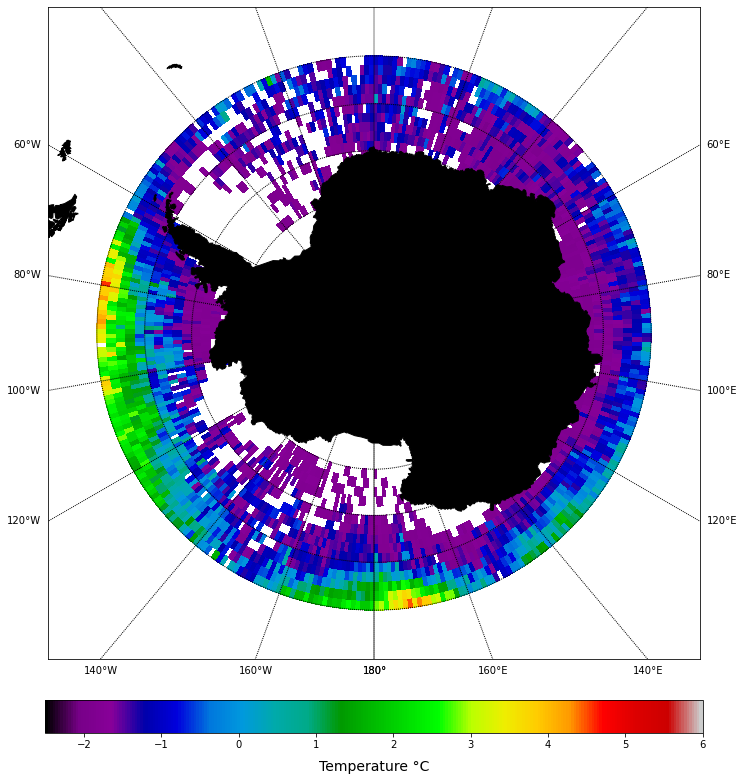

In [15]:
# Load / Create the Lat-Long-Depth Grid of the Seasonal Mean Temperature Field
# Plot Horizontal Sections of the Seasonal Mean Temperature Field
resolution = 1
#dbars = [0, 5, 10, 15, 20, 30, 50, 75, 100, 125, 150, 175, 190, 199]
title="Temperature (ºC)"
dbars = [0]
tmin=-2.5;tmax=6;
for season in ["Winter"]:#, "Summer"]:
    try:
        #argo_pts_grid = np.load(f"argo_pts_grid_{season}.npy")
        argo_temp = np.load(f"argo_temp_grid_withdepth_{season}.npy")
        seal_temp = np.load(f"seal_temp_grid_withdepth_{season}.npy")
        combined_temp = np.load(f"combined_temp_grid_withdepth_{season}.npy")
    except:
        argo_temp = load_netcdf_grid(filter_season = season, with_depth=True, resolution = resolution)
        seal_temp = load_netcdf_grid("seal", filter_season = season, with_depth=True, resolution = resolution)
        combined_temp = np.nanmean((argo_temp, seal_temp), axis=0)
        np.save("argo_temp_grid_withdepth_{}".format(season), argo_temp)
        np.save("seal_temp_grid_withdepth_{}".format(season), seal_temp)
        np.save("combined_temp_grid_withdepth_{}".format(season), combined_temp)
    interp_temp = interp_nans(combined_temp[:,:,0])
    argomean = np.round(np.nanmean(argo_temp), 2)
    sealmean = np.round(np.nanmean(seal_temp), 2)
    combmean = np.round(np.nanmean(combined_temp), 2)
    interpmean = np.round(np.nanmean(interp_temp), 2)
    for db in dbars:
        print("valor minimo e maximo", np.nanmin(combined_temp[:,:,db]),np.nanmax(combined_temp[:,:,db]))
        #dbs = "between {}-{} dbar ".format(db*10, (db+1)*10)
        #title = a_title + "\n" + mtf + dbs + "for {}".format(season)
        #plot_grid(argo_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)
        #title = "Argo data 0-10 decibar mean temperature for {}\nMean across all points = {}".format(season, argomean)
        #title = s_title + "\n" + mtf + dbs + "for {}".format(season)
        #plot_grid(seal_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)
        #title = comb_title + "\n" + mtf + dbs + "for {}".format(season)
        plot_grid(combined_temp[:,:,db], title=title, resolution = resolution, vmin=tmin, vmax=tmax)

valor minimo e maximo 32.91356065538194 34.5998774937221


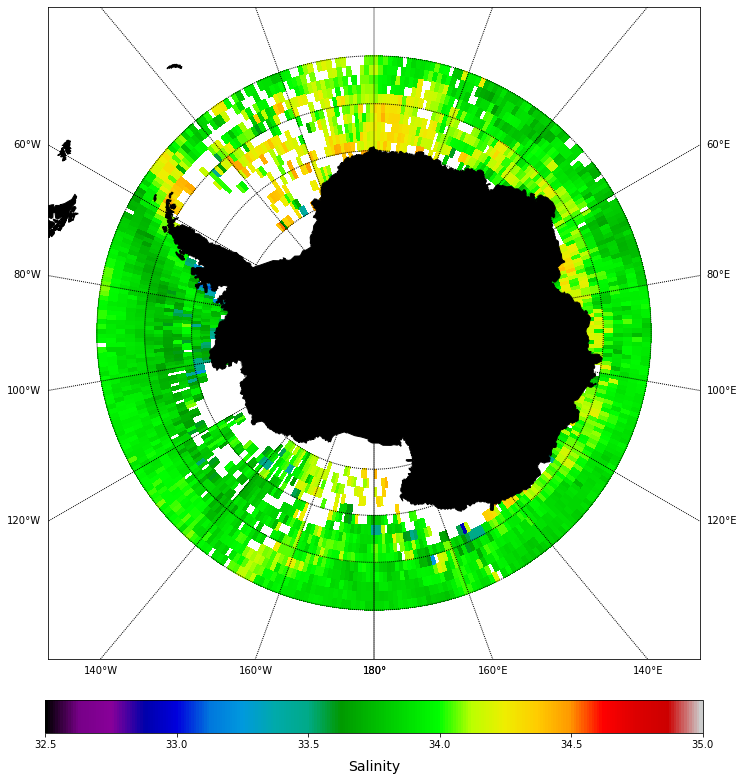

In [16]:
# Load / Create the Lat-Long-Depth Grid of the Seasonal Mean Salinity Field
# Plot Horizontal Sections of the Seasonal Mean Salinity Field
resolution = 1
#dbars = [0, 5, 10]
smin=32.5;smax=35
dbars = [0]
title="Salinity"
for season in ["Winter"]:#, "Summer"]:
    try:
        #argo_pts_grid = np.load(f"argo_pts_grid_{season}.npy")
        argo_sal = np.load(f"argo_sal_grid_withdepth_{season}.npy")
        seal_sal = np.load(f"seal_sal_grid_withdepth_{season}.npy")
        combined_sal = np.load(f"combined_sal_grid_withdepth_{season}.npy")
    except:
        argo_sal = load_netcdf_grid(target_var = "sal", filter_season = season, with_depth=True, resolution = resolution)
        seal_sal = load_netcdf_grid("seal", target_var = "sal", filter_season = season, with_depth=True, resolution = resolution)
        combined_sal = np.nanmean((argo_sal, seal_sal), axis=0)
        np.save("argo_sal_grid_withdepth_{}".format(season), argo_sal)
        np.save("seal_sal_grid_withdepth_{}".format(season), seal_sal)
        np.save("combined_sal_grid_withdepth_{}".format(season), combined_sal)
    interp_sal = interp_nans(combined_sal[:,:,0])
    argo_s_mean = np.round(np.nanmean(argo_sal), 2)
    seal_s_mean = np.round(np.nanmean(seal_sal), 2)
    comb_s_mean = np.round(np.nanmean(combined_sal), 2)
    interp_s_mean = np.round(np.nanmean(interp_sal), 2)
    for db in dbars:
        dbs = "between {}-{} dbar ".format(db*10, (db+1)*10)
        #title = a_title + "\n" + msf + dbs + "for {}".format(season)
        print("valor minimo e maximo", np.nanmin(combined_sal[:,:,db]),np.nanmax(combined_sal[:,:,db]))
        #plot_grid(argo_sal[:,:,db], title=title, cbtitle="Salinity", resolution = resolution, vmin=smin, vmax=smax)
        #title = "Argo data 0-10 decibar mean temperature for {}\nMean across all points = {}".format(season, argomean)
        #title = s_title + "\n" + msf + dbs + "for {}".format(season)
        #plot_grid(seal_sal[:,:,db], title=title, cbtitle="Salinity", resolution = resolution, vmin=smin, vmax=smax)
        #title = comb_title + "\n" + msf + dbs + "for {}".format(season)
        plot_grid(combined_sal[:,:,db], title=title, cbtitle="Salinity", resolution = resolution, vmin=smin, vmax=smax)   

In [ ]:
print(argo_temp_grid_withdepth.shape, seal_temp_grid_withdepth.shape, argo_temp_grid_withdepth.shape)
#print(max(argo_temp[:,:,0]))
#print(argo_lats.shape, argo_lons.shape)
#print(seal_lats.shape, seal_lons.shape)
#print(argo_lats)

In [17]:
# Load / Create the Lat-Long-Depth Grid of the Climatological Temperature Field
resolution = 1
try:
    argo_temp_grid_withdepth = np.load("argo_temp_grid_withdepth.npy")
    seal_temp_grid_withdepth = np.load("seal_temp_grid_withdepth.npy")
    combined_temp_grid_withdepth = np.load("combined_temp_grid_withdepth.npy")
except:
    argo_temp_grid_withdepth = load_netcdf_grid(with_depth=True, resolution = resolution)
    seal_temp_grid_withdepth = load_netcdf_grid("seal", with_depth=True, resolution = resolution)
    combined_temp_grid_withdepth = np.nanmean((argo_temp_grid_withdepth, seal_temp_grid_withdepth), axis=0)
    np.save("argo_temp_grid_withdepth", argo_temp_grid_withdepth)
    np.save("seal_temp_grid_withdepth", seal_temp_grid_withdepth)
    np.save("combined_temp_grid_withdepth", combined_temp_grid_withdepth)

In [18]:
# Load / Create the Lat-Long-Depth Grid of the Standard Deviation from the Climatological Temperature Field
resolution = 1
try:
    argo_sd_temp_grid_withdepth = np.load("argo_sd_temp_grid_withdepth.npy")
    seal_sd_temp_grid_withdepth = np.load("seal_sd_temp_grid_withdepth.npy")
    combined_sd_temp_grid_withdepth = np.load("combined_sd_temp_grid_withdepth.npy")
except:
    argo_sd_temp_grid_withdepth = load_netcdf_grid_sd(with_depth=True, resolution = resolution)
    seal_sd_temp_grid_withdepth = load_netcdf_grid_sd("seal", with_depth=True, resolution = resolution)
    combined_sd_temp_grid_withdepth = np.nanmean((argo_sd_temp_grid_withdepth, seal_sd_temp_grid_withdepth), axis=0)
    np.save("argo_sd_temp_grid_withdepth", argo_sd_temp_grid_withdepth)
    np.save("seal_sd_temp_grid_withdepth", seal_sd_temp_grid_withdepth)
    np.save("combined_sd_temp_grid_withdepth", combined_sd_temp_grid_withdepth)

In [19]:
# Load / Create the Lat-Long-Depth Grid of the Climatological Salinity Field
resolution = 1
try:
    argo_sal_grid_withdepth = np.load("argo_sal_grid_withdepth.npy")
    seal_sal_grid_withdepth = np.load("seal_sal_grid_withdepth.npy")
    combined_sal_grid_withdepth = np.load("combined_sal_grid_withdepth.npy")
except:
    argo_sal_grid_withdepth = load_netcdf_grid(target_var = "sal", with_depth=True, resolution = resolution)
    seal_sal_grid_withdepth = load_netcdf_grid("seal", target_var = "sal", with_depth=True, resolution = resolution)
    combined_sal_grid_withdepth = np.nanmean((argo_sal_grid_withdepth, seal_sal_grid_withdepth), axis=0)
    np.save("argo_sal_grid_withdepth", argo_sal_grid_withdepth)
    np.save("seal_sal_grid_withdepth", seal_sal_grid_withdepth)
    np.save("combined_sal_grid_withdepth", combined_sal_grid_withdepth)

In [ ]:
print(argo_temp_grid_withdepth.shape, seal_temp_grid_withdepth.shape, combined_temp_grid_withdepth.shape)

In [ ]:
#dbars = [0, 4, 9, 14, 19, 29, 49, 69, 99, 124, 149, 174, 189, 199]
dbars = [124, 174]
#dbars = [0]

In [ ]:
# Plot Climatological Temperature Field
tmin=-2; tmax=3;
for db in dbars:
    #Argo data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    #dbs = "{}-{} dbar".format(db*10, (db+1)*10)
    dbs = "between {}-{} dbar".format(db*10, (db+1)*10)
    #plot_grid(argo_temp_grid_withdepth[:,:,db], vmin=tmin, vmax=tmax)
    #plot_grid(seal_temp_grid_withdepth[:,:,db], vmin=tmin, vmax=tmax)
    print("valor minimo e maximo", np.nanmin(combined_temp_grid_withdepth[:,:,db]),np.nanmax(combined_temp_grid_withdepth[:,:,db]))
    plot_grid(combined_temp_grid_withdepth[:,:,db], resolution=resolution, vmin=tmin, vmax=tmax)
    #plot_grid(argo_temp_grid_withdepth[:,:,db], title=a_title + "\n" + mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    #plot_grid(seal_temp_grid_withdepth[:,:,db], title=s_title + "\n" + mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    #plot_grid(combined_temp_grid_withdepth[:,:,db], title=comb_title+ "\n"+ mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    #plot_grid(combined_temp_grid_withdepth[:,:,db], title=dbs, resolution=resolution, vmin=tmin, vmax=tmax)
    #interp = interp_nans(combined_temp_grid_withdepth[:,:,db])
    #plot_grid(interp, title=interp_title + "\n" + mtf + dbs, resolution=resolution, vmin=tmin, vmax=tmax)

In [ ]:
#dbars = [0, 4, 9, 14, 19, 29, 49, 69, 99, 124, 149, 174, 189, 199]
dbars = [19, 29, 49, 69]
smin=33.8; smax=35;

# Plot Climatological Salinity Field

for db in dbars:
    #Argo data\n0-10 decibar mean temperature for {}\nMean across all points = {}".format(calendar.month_abbr[month], argomean)
    #dbs = "{}-{} dbar".format(db*10, (db+1)*10)
    dbs = "between {}-{} dbar".format(db*10, (db+1)*10)
    #plot_grid(argo_sal_grid_withdepth[:,:,db], title=a_title + "\n" + msf + dbs , cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)
    #plot_grid(seal_sal_grid_withdepth[:,:,db], title=s_title + "\n" + msf + dbs , cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)
    #plot_grid(combined_sal_grid_withdepth[:,:,db], title=comb_title + "\n" + msf + dbs , cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)
    #interp = interp_nans(combined_sal_grid_withdepth[:,:,db])
    #plot_grid(interp, title=interp_title + "\n" + msf + dbs, cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)
    print("valor minimo e maximo", np.nanmin(combined_sal_grid_withdepth[:,:,db]),np.nanmax(combined_sal_grid_withdepth[:,:,db]))
    plot_grid(combined_sal_grid_withdepth[:,:,db], cbtitle="Salinity", resolution=resolution, vmin=smin, vmax=smax)

In [ ]:
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
#m.drawcoastlines()
#m.fillcontinents(color='black',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-60, 0, 20))
m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
#m.drawmapboundary(fill_color='aqua')
m.etopo()
plt.title("Bathymetry south of 60S")

In [97]:
import pylab as plot
params = {'legend.fontsize': 14,
          'legend.handlelength': 1,
          'legend.labelspacing': 0.25,
          'legend.handletextpad': 0.2,
          'legend.frameon': False,
          'legend.markerscale': 2.0}
plot.rcParams.update(params)

def format_axes_b(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(-1.5, 1950, "4.%d" % (i+1), va="center", ha="center", fontsize=14, color='black')
        ax.tick_params(axis="both", direction='inout', which='major', labelsize=16, labelbottom=True, labelleft=True)
        ax.set_ylim(p_max, p_min); 
        ax.set_xlim(t_min, t_max)
        ax1.set_ylabel("Depth (dbar)", fontsize="18")
        ax2.set_ylabel("Depth (dbar)", fontsize="18")
        ax2.set_xlabel("Temperature", fontsize="18")
        ax6.set_xlabel("Temperature", fontsize="18")
        ax1.tick_params(labelbottom=False)

(0, 180, -90, 0.0, 90)
(0, 0, 90, 180, 270)
0 180
-1.7390999794006348 3.3632362650500403 33.731198120117185 34.73633130391439
[33.3, 33.5, 33.7, 33.9, 34.1, 34.3, 34.5, 34.7, 34.8]
90 -90
-1.8242663070559502 3.86983315149943 33.45185068491343 34.73500061035156
[33.3, 33.5, 33.7, 33.9, 34.1, 34.3, 34.5, 34.7, 34.8]
180 0.0
-1.7166638456541916 1.002409734641369 33.870741965553975 34.69793701171875
[33.3, 33.5, 33.7, 33.9, 34.1, 34.3, 34.5, 34.7, 34.8]
270 90
-1.8788625001907349 1.8338245834623064 33.369389257123395 34.735844135284424
[33.3, 33.5, 33.7, 33.9, 34.1, 34.3, 34.5, 34.7, 34.8]


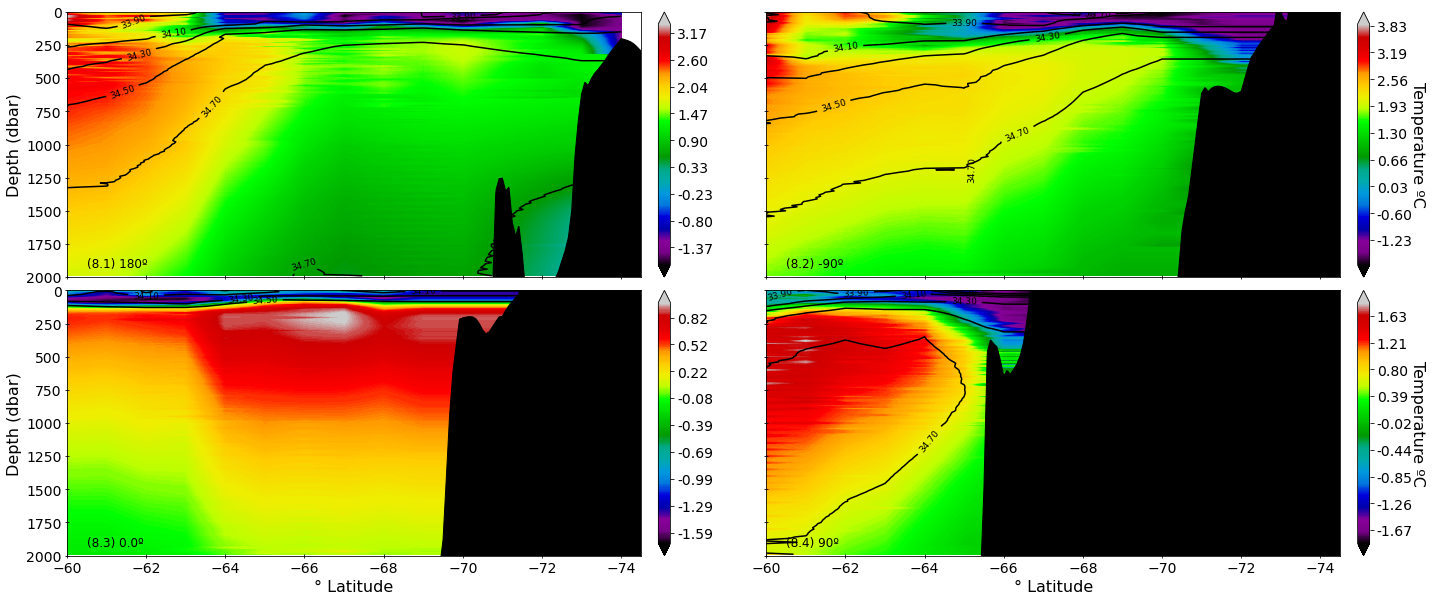

In [98]:
i = fig = b = c = d = e = f = g = long = 0
resolution = 1
cbtitle = title = parameter = "Temperature ºC"
def plot_cross_slope_(grid1, grid2, title=title, lon=long, i = i, fig = fig, cbtitle = cbtitle, resolution = resolution, 
                      labelleft=True, labelbottom=True, tmin=b, tmax=c, smin=d, smax=e, dmin = f, dmax = g):
    ax = fig.add_subplot(2, 2, i)
    ax.tick_params(axis="both", direction='inout', labelsize=14, labelbottom=True, labelleft=True, labeltop=False)
    y = np.arange(-60, -75, -1/resolution)
    z = np.arange(0, 2000, 10)
    levels = np.arange(np.nanmin(grid1), np.nanmax(grid1), .01)
    im = ax.contourf(y, z, grid1.T, cmap="nipy_spectral", levels = levels, extend="both")
    ax.text(-60.5, 1900, "(8.%d) {}º".format(lon) % (i), va="center", ha="left", fontsize=12, color='black')
    
    #ax.set_title("{} at {} W at {} resolution".format(title,lon, 1 / resolution))
    #ax.set_title("at {}".format(lon))
    
    cbticks = np.arange(-2.5,tmax,((tmax-tmin)/9))
    cb = fig.colorbar(im, pad=0.025, format='%.2f', extend='both',ticks=cbticks)
    cb_ticklabel_size = 14 # Adjust as appropriate.
    cb.ax.tick_params(labelsize=cb_ticklabel_size)
        
    
    label_size = 16 # Adjust as appropriate.
    #ax.tick_params(axis="both", direction='inout', which='major')
    if i<3:
        ax.tick_params(labelbottom=False)
        ax.tick_params(labeltop=False, direction='inout')
    else:
        ax.tick_params(labelbottom=True)
        ax.set_xlabel("° Latitude", fontsize=label_size)
    if (i % 2) == 0:
        ax.tick_params(labelleft=False)
        cb.set_label(cbtitle, rotation=270, fontsize="16", labelpad=12.5) 
        
    else:
        ax.set_ylabel("Depth (dbar)", fontsize=label_size)
    smin= 33; smax=35
    contour_levels = [33.3, 33.5, 33.7, 33.9, 34.1, 34.3, 34.5, 34.7, 34.8]
    #contour_levels = np.linspace(smin, smax, num=21) # Adjust as appropriate.
    print(contour_levels)
    CS = ax.contour(y, z, grid2.T, #10,
                 colors='k', vmin=smin, vmax=smax, levels=contour_levels) # not sure if negative contours will be dashed by default
    ax.clabel(CS, fontsize=9, inline=1, fmt='%1.2f')
    #cb = fig.colorbar(im, CS, pad=0.025, format='%.2f', extend='both',ticks=cbticks)
    
    db = oceansdb.ETOPO()
    y = np.arange(-60, -75, -.01)
    h = -db['topography'].extract(lat=y, lon=long)["height"]
    #ax.plot(y, h)
    ax.fill_between(y, 5000, h, color='black')
    ax.set_ylim(2000, 0)
    ax.set_xlim(-60, -74.5)

#longit = (0, - 178.5, -90.5, 0.5, 90) # Half Degree Resolution
longit = (0,180,-90,0.,90) # One Degree Resolution
print(longit[:])
z_grid = (0, 0, 90, 180, 270) # One Degree Resolution
#z_grid = (0, 3, 179, 361, 540) # Half Degree Resolution
print(z_grid[:])
fig = plt.figure(figsize=(25,10))
fig.subplots_adjust(hspace=0.05, wspace=0.005)
for i in range(1, 5):
    a = z_grid[i]
    long = longit[i]
    print(a,long) 
    xsection_temp = combined_temp_grid_withdepth[:,a,:]
    xsection_temp = interp_nans(xsection_temp)
    xsection_sal = argo_sal_grid_withdepth[:,a,:]
    xsection_sal = interp_nans(xsection_sal)
    b,c,d,e = [np.nanmin(xsection_temp),np.nanmax(xsection_temp),np.nanmin(xsection_sal),np.nanmax(xsection_sal)]
    print(b,c,d,e)
    plot_cross_slope_(xsection_temp, xsection_sal, lon = long, i = i, fig = fig, tmin=b, tmax=c, smin=d, smax=e)
    
#fig.suptitle("Cross section of {} at {} resolution".format(title, 1 / resolution), fontsize="20")    
plt.show()

In [ ]:
longitude = 180
cbtitle = title = "Temperature (°C)"
def plot_cross_slope(grid, title=title, lon=long, cbtitle=title, resolution = resolution):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    y = np.arange(-60, -75, -1/resolution)
    z = np.arange(0, 2000, 10)
    levels = np.arange(np.nanmin(grid), np.nanmax(grid), .01)
    im = ax.contourf(y, z, grid.T, cmap="nipy_spectral", levels = levels, extend="both")
    ax.set_xlabel("° Latitude")
    ax.set_ylabel("Depth (dbar)")
    ax.set_title("{} at {} W at {} resolution".format(title,longitude, 1 / resolution))
    cb = fig.colorbar(im, pad=0.025)
    cb.set_label(cbtitle, rotation=270, fontsize="14", labelpad=12.5)
    #minor_thresholds=(2, 0.5)
    
    db = oceansdb.ETOPO()
    y = np.arange(-60, -75, -.01)
    h = -db['topography'].extract(lat=y, lon=long)["height"]
    #ax.plot(y, h)
    ax.fill_between(y, 5000, h, color='black')
    ax.set_ylim(2000, 0)
    ax.set_xlim(-60, -74.5)
   
    plt.show()

zonal_grid = 90
combinedd = combined_temp_grid_withdepth[:,zonal_grid,:]
interp = interp_nans(combinedd)
plot_cross_slope(combinedd, resolution = resolution)
plot_cross_slope(interp, resolution = resolution)

In [ ]:
def dens_smow(T):
    '''
    Function calculates density of standard mean ocean water (pure water) using EOS 1980.
    INPUT: T = temperature [degree C (ITS-90)]
    OUTPUT: dens = density [kg/m^3]
    '''
    a0 = 999.842594;a1 = 6.793952e-2;a2 = -9.095290e-3;a3 = 1.001685e-4;a4 = -1.120083e-6;a5 = 6.536332e-9
    T68 = T * 1.00024
    dens = (a0 + (a1 + (a2 + (a3 + (a4 + a5*T68)*T68)*T68)*T68)*T68)
    return dens

def dens0(S, T):
    '''
    Function calculates density of sea water at atmospheric pressure
    USAGE:  dens0 = dens0(S,T)
    DESCRIPTION:
        Density of Sea Water at atmospheric pressure using
        UNESCO 1983 (EOS 1980) polynomial.
    INPUT:  (all must have same dimensions)
        S = salinity    [psu      (PSS-78)]
        T = temperature [degree C (ITS-90)]
    OUTPUT:
        dens0 = density  [kg/m^3] of salt water with properties S,T,
        P=0 (0 db gauge pressure)
    '''
    assert S.shape == T.shape
    T68 = T * 1.00024
    # UNESCO 1983 eqn(13) p17.
    b0 = 8.24493e-1;b1 = -4.0899e-3;b2 = 7.6438e-5;b3 = -8.2467e-7;b4 = 5.3875e-9
    c0 = -5.72466e-3;c1 = +1.0227e-4;c2 = -1.6546e-6
    d0 = 4.8314e-4
    dens = (dens_smow(T) + (b0+ (b1+(b2+(b3+b4*T68)*T68)*T68)*T68)*S + (c0+(c1+c2*T68)*T68)*S*np.sqrt(S)+ d0*(S**2) )
    return dens

In [ ]:
parameter = "Density (kg/m3)"
dens = dens0(combined_sal_grid_withdepth, combined_temp_grid_withdepth)
dbars = [50]
for db in dbars:
    rhomin, rhomax = [np.nanmin(dens[:,:,db]),np.nanmax(dens[:,:,db])]
    dbs = "from {}-{} dbar".format(db*10, (db+1)*10)
    plot_grid(dens[:,:,db], title=comb_title + "\n" + msd + dbs, cbtitle=parameter, resolution=resolution, vmin=rhomin, vmax=rhomax)
    #interp = interp_nans(dens[:,:,db])
    #print(np.nanmin(interp), np.nanmax(interp))
    #plot_grid(interp, title="Interpolated gridded seal+argo density data " + dbs, cbtitle="Density", resolution=resolution, vmin=rhomin, vmax=rhomax)

In [ ]:
i = fig = b = c = d = e = f = g = long = 0
resolution = 1
cbtitle = title = parameter = "Density (kg/m3)"

def plot_cross_slope_dens(grid1, grid2, title=title, lon=long, i = i, fig = fig, cbtitle = cbtitle, resolution = resolution, 
                      labelleft=True, labelbottom=True, tmin=b, tmax=c, smin=d, smax=e, dmin = f, dmax = g):
    ax = fig.add_subplot(2, 2, i)
    ax.tick_params(axis="both", direction='inout', labelsize=14, labelbottom=True, labelleft=True, labeltop=False)
    y = np.arange(-60, -75, -1/resolution)
    z = np.arange(0, 2000, 10)
    levels = np.arange(np.nanmin(grid1), np.nanmax(grid1), .01)
    im = ax.contourf(y, z, grid1.T, cmap="nipy_spectral", levels = levels, extend="both")
    ax.text(-60.5, 1900, "(8.%d) {}º".format(lon) % (i), va="center", ha="left", fontsize=12, color='black')
    
    #ax.set_title("{} at {} W at {} resolution".format(title,lon, 1 / resolution))
    #ax.set_title("at {}".format(lon))
    
    cbticks = np.arange(dmin,dmax,((dmax-dmin)/9))
    cb = fig.colorbar(im, pad=0.025, format='%.1f', extend='both',ticks=cbticks)
    cb_ticklabel_size = 14 # Adjust as appropriate.
    cb.ax.tick_params(labelsize=cb_ticklabel_size)
        
    
    label_size = 16 # Adjust as appropriate.
    #ax.tick_params(axis="both", direction='inout', which='major')
    if i<3:
        ax.tick_params(labelbottom=False)
        ax.tick_params(labeltop=False, direction='inout')
    else:
        ax.tick_params(labelbottom=True)
        ax.set_xlabel("° Latitude", fontsize=label_size)
    if (i % 2) == 0:
        ax.tick_params(labelleft=False)
        cb.set_label(cbtitle, rotation=270, fontsize="16", labelpad=12.5) 
        
    else:
        ax.set_ylabel("Depth (dbar)", fontsize=label_size)
    
    contour_levels = np.linspace(tmin, tmax, num=10) # Adjust as appropriate.
    print(contour_levels)
    CS = ax.contour(y, z, grid2.T, #10,
                 colors='k', vmin=tmin, vmax=tmax, levels=contour_levels) # not sure if negative contours will be dashed by default
    ax.clabel(CS, fontsize=9, inline=1, fmt='%1.2f')
    #cb = fig.colorbar(im, CS, pad=0.025, format='%.2f', extend='both',ticks=cbticks)
    
    db = oceansdb.ETOPO()
    y = np.arange(-60, -75, -.01)
    h = -db['topography'].extract(lat=y, lon=long)["height"]
    #ax.plot(y, h)
    ax.fill_between(y, 5000, h, color='black')
    ax.set_ylim(2000, 0)
    ax.set_xlim(-60, -74.5)

fig = plt.figure(figsize=(25,10))
fig.subplots_adjust(hspace=0.05, wspace=0.005)
for i in range(1, 5):
    a = z_grid[i]
    long = longit[i]
    print(a,long) 
    xsection_dens = dens[:,a,:]
    xsection_dens = interp_nans(xsection_dens)
    xsection_temp = combined_temp_grid_withdepth[:,a,:]
    xsection_temp = interp_nans(xsection_temp)
    xsection_sal = argo_sal_grid_withdepth[:,a,:]
    xsection_sal = interp_nans(xsection_sal)
    b,c,d,e,f,g = [np.nanmin(xsection_temp),np.nanmax(xsection_temp),np.nanmin(xsection_sal),np.nanmax(xsection_sal), np.nanmin(xsection_dens),np.nanmax(xsection_dens)]
    print(b,c,d,e,f,g)
    plot_cross_slope_dens(xsection_dens, xsection_temp, lon = long, i = i, fig = fig, tmin=b, tmax=c, smin=d, smax=e, dmin=f, dmax=g)
    
#fig.suptitle("Cross section of {} at {} resolution".format(title, 1 / resolution), fontsize="20")    
plt.show()

In [ ]:
parameter = title = "Density (kg/m3)"
plot_cross_slope(dens[:,2,:], title=title, cbtitle=parameter, resolution=resolution)
#plot_cross_slope(interp_nans(dens[:,2,:]), title="Interpolated density at 179° W", cbtitle="Density", resolution=resolution)

In [ ]:
#Cell added on 21/10/2019 - still testing
# adding function for TS Diagram
dens = dens0(argo_sal_grid_withdepth, argo_temp_grid_withdepth)
# print(combined_temp_grid_withdepth[0])
#shape of dens - (30,720,200) = (latitude, longitude, vertical layers)

cmap = plt.get_cmap('nipy_spectral');cmap.set_bad(color='white')

fig = plt.figure(4,figsize=(15,15))  #TS-diagram of Argo profiles in the Ross Sea Slice
#plt.scatter(argo_sal_grid_withdepth[0:10],argo_temp_grid_withdepth[0:10],s = 2,c=dens[0:10],cmap = cmap, edgecolors='none',alpha=0.8)
plt.scatter(argo_sal_grid_withdepth[5:14,:,0:9],argo_temp_grid_withdepth[5:14,:,0:9],s = 2,c=dens[5:14,:,0:9],cmap = cmap, edgecolors='none',alpha=0.8)
plt.xlim(np.nanmin(argo_temp_grid_withdepth[5:14,:,0:9]), np.nanmax(argo_temp_grid_withdepth[5:14,:,0:9]))
plt.xlim(np.nanmin(argo_sal_grid_withdepth[5:14,:,0:9]), np.nanmax(argo_sal_grid_withdepth[5:14,:,0:9]))
#plt.xlim(33.8,35);plt.ylim(-2.5,5)
plt.clb = plt.colorbar();plt.clb.ax.set_title('Density (kg/m$^3$)')                  
plt.xlabel('Pratical salinity',fontsize = 18);
plt.ylabel('Temperature ($^oC$)',fontsize = 18)
#ax.set_xlabel('Pratical salinity',fontsize = 18);
#ax.set_ylabel('Temperature ($^oC$)',fontsize = 18)
plt.title('T-S diagram, Argo profiles',fontsize = 20)
# plt.axis('tight')
plt.show()
#     for i in range(0, len(FILES)):
#         read = Dataset(source + count_60[j][1] + '/profiles/' + FILES[i], mode = 'r')
#         Lat = read.variables['LATITUDE'][:]
#         Lon = read.variables['LONGITUDE'][:]
#         if Lon[0] < -140, Lon[0] > 160:
#             Temp = read.variables['TEMP'][:]
#             Psal = read.variables['PSAL'][:]
#             sigma = dens0(Psal[0],Temp[0])
#             scatter(Psal[0],Temp[0],s = 2,c=sigma,cmap = cmap, edgecolors='none',alpha=0.8)

# xlim(33.8,35);ylim(-2.5,5)
# clb = colorbar()#;clb.ax.set_title('Density (kg/m$^3$)')                  
# axis('tight');grid('on',alpha=0.2)
# # savepath = os.path.join('C:/Users/fvie285/Desktop/PhD_Project/Data/figures/Argo_South_of_50/aoml_figures/TS_diagram_RSS.png')
# # savefig(savepath, bbox_inches='tight', dpi=300) 
# show()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
print(argo_sal_grid_withdepth.shape)
seal_counts = np.sum(~np.isnan(seal_sal_grid_withdepth), axis=2)
argo_counts = np.sum(~np.isnan(argo_sal_grid_withdepth), axis=2)
print(np.argwhere(seal_counts + argo_counts >= 300))
depth = np.arange(0, 2000, 10)
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_title("Salinity profile")
ax.set_ylim(2000, 0)
from scipy.signal import savgol_filter
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

ax.plot(argo_sal_grid_withdepth[0, 0, :], depth)
ax.plot(seal_sal_grid_withdepth[0, 0, :], depth)
#ax.plot(savgol_filter(fill_nan(argo_sal_grid_withdepth[11, 466, :]),  51, 3), depth)
#ax.plot(savgol_filter(fill_nan(seal_sal_grid_withdepth[11, 466, :]),  51, 3), depth)
ax.legend(["argo", "seal"])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,20))
print(argo_sal_grid_withdepth.shape)
depth = np.arange(0, 2000, 10)
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_ylim(2000, 0)
long = 2
long_label = (long/2)-180
lat_ini = "60ºS"
lat_end = "74.5ºS"
ax.set_title(a_title + "\nSalinity mean profile at {}º, from {} to {} latitude".format(long_label,lat_ini,lat_end))
for dim_lat in range(0,29):
    try:
        filtered = savgol_filter(fill_nan(argo_sal_grid_withdepth[dim_lat, long, :]), 51, 3)
        ax.plot(filtered, depth)
    except:
        pass
    #ax.legend(["argo[dim_lat]"])
#ax.plot(seal_sal_grid_withdepth[4, 715, :], depth)
#ax.legend(["argo", "seal"])
#print(argo_lats)
#print(argo_lats.shape)
#print(argo_lons.shape)

In [ ]:
argo_temp_grid_withdepth_summer = np.load("argo_temp_grid_withdepth_Summer.npy")
argo_temp_grid_withdepth_winter = np.load("argo_temp_grid_withdepth_Winter.npy")
seal_temp_grid_withdepth_summmer = np.load("seal_temp_grid_withdepth_Summer.npy")
seal_temp_grid_withdepth_winter = np.load("seal_temp_grid_withdepth_Winter.npy")
combined_temp_grid_withdepth_summer = np.load("combined_temp_grid_withdepth_Summer.npy")
combined_temp_grid_withdepth_winter = np.load("combined_temp_grid_withdepth_Winter.npy")

In [ ]:
argo_sal_grid_withdepth_summer = np.load("argo_sal_grid_withdepth_Summer.npy")
argo_sal_grid_withdepth_winter = np.load("argo_sal_grid_withdepth_Winter.npy")
seal_sal_grid_withdepth_summer = np.load("seal_sal_grid_withdepth_Summer.npy")
seal_sal_grid_withdepth_winter = np.load("seal_sal_grid_withdepth_Winter.npy")
combined_sal_grid_withdepth_summer = np.load("combined_sal_grid_withdepth_Summer.npy")
combined_sal_grid_withdepth_winter = np.load("combined_sal_grid_withdepth_Winter.npy")

In [ ]:
for season in ["Summer", "Winter"]:
    argo_temp = np.load("argo_temp_grid_withdepth_{}.npy".format(season))
    seal_temp = np.load("seal_temp_grid_withdepth_{}.npy".format(season))
    fig, ax = plt.subplots(1, 1, figsize=(10,20))
    depth = np.arange(0, 2000, 10)
    ax.set_xlabel("{} temperature °C".format(season))
    ax.set_ylabel("Depth (dbar)")
    ax.set_title("{} temperature °C profile".format(season))
    ax.set_ylim(2000, 0)
    ax.plot(argo_temp[6, 233, :], depth)
    ax.plot(seal_temp[6, 233, :], depth)
    ax.legend(["argo", "seal"])
    print(argo_temp[8,238])

In [ ]:
resolution = 2
years = [2007, 2011, 2015]
try:
    grids_per_year = np.load("grids_per_year.npy", allow_pickle=True).item()
except:
    grids_per_year = {}
    for y in years:
        for s in ["Summer", "Winter"]:
            start = datetime(y,1,1)
            end = datetime(y + 4,1,1)
            argo_temp_grid_withdepth_yearfiltered = load_netcdf_grid(with_depth=True, resolution = resolution, filter_start = start, filter_end = end, filter_season = s)
            seal_temp_grid_withdepth_yearfiltered = load_netcdf_grid("seal", with_depth=True, resolution = resolution, filter_start = start, filter_end = end, filter_season = s)
            combined_temp_grid_withdepth_yearfiltered = np.nanmean((argo_temp_grid_withdepth_yearfiltered, seal_temp_grid_withdepth_yearfiltered), axis=0)
            if y not in grids_per_year:
                grids_per_year[y] = {
                    "Winter": {},
                    "Summer": {}
                }
            grids_per_year[y][s] = {
                "argo": argo_temp_grid_withdepth_yearfiltered,
                "seal": seal_temp_grid_withdepth_yearfiltered,
                "combined": combined_temp_grid_withdepth_yearfiltered
            }
    np.save("grids_per_year", grids_per_year)

In [ ]:
plt.rcParams['figure.facecolor']='white'
db = 50
for i, y in enumerate(years):
    for s in ["Summer", "Winter"]:
        argo_temp_grid_withdepth_yearfiltered = grids_per_year[y][s]["argo"]
        seal_temp_grid_withdepth_yearfiltered = grids_per_year[y][s]["seal"]
        combined_temp_grid_withdepth_yearfiltered = grids_per_year[y][s]["combined"]
        title = f"at {db * 10}dbar from the year {y}-{y + 4} in {s}"
        plot_grid(argo_temp_grid_withdepth_yearfiltered[:,:,db], title=a_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
        plot_grid(seal_temp_grid_withdepth_yearfiltered[:,:,db], title=s_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
        plot_grid(combined_temp_grid_withdepth_yearfiltered[:,:,db], title=comb_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
        interp = interp_nans(combined_temp_grid_withdepth_yearfiltered[:,:,db])
        plot_grid(interp, title=interp_title + "\n" + title, resolution=resolution, vmin=tmin, vmax=tmax)
    
        if i > 0:
            delta = argo_temp_grid_withdepth_yearfiltered[:,:,db] - grids_per_year[years[i - 1]][s]["argo"][:,:,db]
            print(np.nanmin(delta), np.nanmean(delta), np.nanmax(delta))
            plot_grid(delta, title=comb_title + "\n" + f"Delta from {years[i - 1]} - {y} in {s} at {db}dbar", resolution=resolution)

In [ ]:
print(grids_per_year.keys())
delta = grids_per_year[2015]["Winter"]["argo"][:,:,db] - grids_per_year[2011]["Winter"]["argo"][:,:,db]
print(np.nanmax(delta))
print(np.where(delta == np.nanmax(delta)))
delta[10,636]
print(grids_per_year[2015]["Winter"]["argo"][10,636,db])
print(grids_per_year[2011]["Winter"]["argo"][10,636,db])
print(10/2, 636 /2 - 180)

In [ ]:
mask = ((argo["lat"] < -64.75) & (argo["lat"] > -65.25) & (argo["lon"] > 137.25) & (argo["lon"] < 138.75))
for i in np.flatnonzero(mask):
    pres = argo["pressure"][i] / 10
    pres = np.floor(argo["pressure"][i] / 10).astype(int)
    depthmask = pres == 50
    temps = np.copy(argo["temperature"][i][depthmask])
    print(f'i={i},lat={argo["lat"][i]},lon={argo["lon"][i]},dt={argo["datetime"][i]},temps={np.around(temps,2)},mean={np.around(np.nanmean(temps), 2)}')

In [ ]:
mask = ((argo["lat"] < -64.75) & (argo["lat"] > -65.25) & (argo["lon"] > 137.25) & (argo["lon"] < 138.75))    
fig, ax = plt.subplots(1, 1, figsize=(10,20))
ax.set_xlabel("Salinity")
ax.set_ylabel("Depth (dbar)")
ax.set_ylim(2000, 0)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

for i in np.flatnonzero(mask):
    sal = argo["salinity"][i]
    pressure = argo["pressure"][i]
    #sal = savgol_filter(sal, 69, 1)
    ax.plot(sal, pressure)